In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(600, 400))
    dis.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  freeglut3
Suggested packages:
  libgle3
The following NEW packages will be installed:
  freeglut3 python-opengl
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 570 kB of archives.
After this operation, 5,733 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 freeglut3 amd64 2.8.1-3 [73.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 570 kB in 1s (910 kB/s)
Selecting previously unselected package freeglut3:amd64.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../freeglut3_2.8.1-3_amd64.deb ...
Unpacking freeglut3:am

In [ ]:
import random
from typing import Dict, List, Tuple
import math
import gym
from gym import spaces
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Normal

In [ ]:
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [ ]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        """Initialize."""
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, 4], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros([size], dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        """Store the transition in buffer."""
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

In [ ]:
def init_layer_uniform(layer: nn.Linear, init_w: float = 3e-3) -> nn.Linear:
    """Init uniform parameters on the single layer."""
    layer.weight.data.uniform_(-init_w, init_w)
    layer.bias.data.uniform_(-init_w, init_w)

    return layer

class Actor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int,
        log_std_min: float = -20,
        log_std_max: float = 2,
    ):
        """Initialize."""
        super(Actor, self).__init__()
        
        # set the log std range
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        # set the hidden layers
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        
        # set log_std layer
        self.log_std_layer = nn.Linear(128, out_dim)
        self.log_std_layer = init_layer_uniform(self.log_std_layer)

        # set mean layer
        self.mu_layer = nn.Linear(128, out_dim)
        self.mu_layer = init_layer_uniform(self.mu_layer)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        
        # get mean
        mu = self.mu_layer(x).tanh()
        
        # get std
        log_std = self.log_std_layer(x).tanh()
        log_std = self.log_std_min + 0.5 * (
            self.log_std_max - self.log_std_min
        ) * (log_std + 1)
        std = torch.exp(log_std)
        
        # sample actions
        dist = Normal(mu, std)
        z = dist.rsample()
        
        # normalize action and log_prob
        # see appendix C of [2]
        action = z.tanh()
        log_prob = dist.log_prob(z) - torch.log(1 - action.pow(2) + 1e-7)
        log_prob = log_prob.sum(-1, keepdim=True)
        
        return action, log_prob
    
    
class CriticQ(nn.Module):
    def __init__(self, in_dim: int):
        """Initialize."""
        super(CriticQ, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)
        self.out = init_layer_uniform(self.out)

    def forward(
        self, state: torch.Tensor, action: torch.Tensor
    ) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        value = self.out(x)
        
        return value
    
    
class CriticV(nn.Module):
    def __init__(self, in_dim: int):
        """Initialize."""
        super(CriticV, self).__init__()
        
        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, 1)
        self.out = init_layer_uniform(self.out)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))
        value = self.out(x)
        
        return value

In [ ]:
class SACAgent:
    """SAC agent interacting with environment."""
    
    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = int(1e4),
        policy_update_freq: int = 2,
    ):
        """Initialize."""
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]

        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
        self.policy_update_freq = policy_update_freq

        self.count = 0
        self.average_delay = []

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)
        
        # automatic entropy tuning
        self.target_entropy = -np.prod((action_dim,)).item()  # heuristic
        self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=3e-4)

        # actor
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        
        # v function
        self.vf = CriticV(obs_dim).to(self.device)
        self.vf_target = CriticV(obs_dim).to(self.device)
        self.vf_target.load_state_dict(self.vf.state_dict())
        
        # q function
        self.qf_1 = CriticQ(obs_dim + action_dim).to(self.device)
        self.qf_2 = CriticQ(obs_dim + action_dim).to(self.device)

        # optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.vf_optimizer = optim.Adam(self.vf.parameters(), lr=3e-4)
        self.qf_1_optimizer = optim.Adam(self.qf_1.parameters(), lr=3e-4)
        self.qf_2_optimizer = optim.Adam(self.qf_2.parameters(), lr=3e-4)
        
        # transition to store in memory
        self.transition = list()
        
        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False
    
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # if initial random action should be conducted
        if self.total_step < self.initial_random_steps and not self.is_test:
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.actor(
                torch.FloatTensor(state).to(self.device)
            )[0].detach().cpu().numpy()
            
        self.transition = [state, selected_action]
        
        return selected_action
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, b = self.env.step(action)
        
        if not self.is_test:
            if b == True:
                self.count += 1
                if self.count%20 == 0:
                    self.transition += [reward, next_state, done]
                    self.memory.store(*self.transition)
            else:
                self.transition += [reward, next_state, done]
                self.memory.store(*self.transition)

        return next_state, reward, done
    
    def update_model(self) -> Tuple[torch.Tensor, ...]:
        """Update the model by gradient descent."""

        device = self.device  # for shortening the following lines
        
        samples = self.memory.sample_batch()
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.FloatTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        new_action, log_prob = self.actor(state)
        # print(action.shape, next_state.shape, action.shape, reward.shape)
        
        # train alpha (dual problem)
        alpha_loss = (
            -self.log_alpha.exp() * (log_prob + self.target_entropy).detach()
        ).mean()

        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()
        
        alpha = self.log_alpha.exp()  # used for the actor loss calculation
        
        # q function loss
        mask = 1 - done
        q_1_pred = self.qf_1(state, action)
        q_2_pred = self.qf_2(state, action)
        v_target = self.vf_target(next_state)
        q_target = reward + self.gamma * v_target * mask
        qf_1_loss = F.mse_loss(q_1_pred, q_target.detach())
        qf_2_loss = F.mse_loss(q_2_pred, q_target.detach())
        
        # v function loss
        v_pred = self.vf(state)
        q_pred = torch.min(
            self.qf_1(state, new_action), self.qf_2(state, new_action)
        )
        v_target = q_pred - alpha * log_prob
        vf_loss = F.mse_loss(v_pred, v_target.detach())
        
        if self.total_step % self.policy_update_freq == 0:
            # actor loss
            advantage = q_pred - v_pred.detach()
            actor_loss = (alpha * log_prob - advantage).mean()
            
            # train actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
        
            # target update (vf)
            self._target_soft_update()
        else:
            actor_loss = torch.zeros(1)
            
        # train Q functions
        self.qf_1_optimizer.zero_grad()
        qf_1_loss.backward()
        self.qf_1_optimizer.step()

        self.qf_2_optimizer.zero_grad()
        qf_2_loss.backward()
        self.qf_2_optimizer.step()
        
        qf_loss = qf_1_loss + qf_2_loss

        # train V function
        self.vf_optimizer.zero_grad()
        vf_loss.backward()
        self.vf_optimizer.step()
        
        return actor_loss.data, qf_loss.data, vf_loss.data, alpha_loss.data

    def train(self, episodes: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        actor_losses, qf_losses, vf_losses, alpha_losses = [], [], [], []
        # self.average_delay = []
        scores = []
        
        for self.total_step in range(episodes):

            state = self.env.reset()   
            done = False
            self.env.step_ = 0
            score = 0

            while not done and self.env.step_ < env.MAX_STEPS:
                env.render()
                action = self.select_action(state)
                next_state, reward, done = self.step(action)

                state = next_state
                score += reward
                self.env.step_ += 1
                print()
            env.render()
            scores.append(score)
            print('End Time', self.env.end_time)
            self.average_delay.append(self.env.end_time.mean())
            plt.plot(self.average_delay)
            plt.show()

            if (len(self.memory) >= self.batch_size):
                losses = self.update_model()

            # if training is ready
            # if (
            #     len(self.memory) >= self.batch_size 
            #     and self.total_step > self.initial_random_steps
            # ):
            #     losses = self.update_model()
            #     actor_losses.append(losses[0])
            #     qf_losses.append(losses[1])
            #     vf_losses.append(losses[2])
            #     alpha_losses.append(losses[3])
            
            # # plotting
            # if self.total_step % plotting_interval == 0:
            #     self._plot(
            #         self.total_step,
            #         scores, 
            #         actor_losses, 
            #         qf_losses, 
            #         vf_losses, 
            #         alpha_losses,
            #     )
                
        self.env.close()
        
    def test(self):
        """Test the agent."""
        self.is_test = True
        
        state = self.env.reset()
        done = False
        score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
            step += 1
        
        print("score: ", score)
        self.env.close()
        
        return frames
    
    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau
        
        for t_param, l_param in zip(
            self.vf_target.parameters(), self.vf.parameters()
        ):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float],
        qf_losses: List[float],
        vf_losses: List[float],
        alpha_losses: List[float],
    ):
        """Plot the training progresses."""
        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (151, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (152, "actor_loss", actor_losses),
            (153, "qf_loss", qf_losses),
            (154, "vf_loss", vf_losses),
            (155, "alpha_loss", alpha_losses),
        ]
        
        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

In [ ]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

In [ ]:
# step = 0

In [ ]:
class UAVEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    MAX_BATTERY_UAV = e_battery_uav = 50000000
    height = ground_length = ground_width = 100
    SUM_TASK_SIZE = curr_sum_task_size = 300 * 1048576
    loc_uav = [50, 50]
    bandwidth_nums = 1
    B = bandwidth_nums * 10 ** 6
    p_noisy_los = 10 ** (-13)
    p_noisy_nlos = 10 ** (-11)
    flight_speed = 50.
    f_ue = 6e8
    f_uav = 6e9
    r = 10 ** (-27)        
    s = 1000
    p_uplink = 0.1
    alpha0 = 1e-5
    v_ue = 1
    t_fly = 1
    t_com = 5
    m_uav = 9.65

    M = 4
    action_dim = 4
    state_dim = 3 * M + 4
    block_flag_list = np.random.randint(0, 2, M)  
    loc_ue_list = np.random.randint(0, 101, size=[M, 2])
    task_list = np.random.dirichlet(np.ones(M))*SUM_TASK_SIZE
    action_bound = [-1, 1]
    
    end_time = np.zeros(M)
    step_ = 0
    MAX_STEPS = 100

    def __init__(self):
        super(UAVEnv, self).__init__()
        self.action_space = spaces.Box( np.array([-1]*self.action_dim), np.array([1]*self.action_dim))
        self.observation_space = spaces.Box( np.array([0]*self.state_dim), 
                                            np.array([self.MAX_BATTERY_UAV, self.SUM_TASK_SIZE, 
                                                      self.SUM_TASK_SIZE, self.SUM_TASK_SIZE, 
                                                      self.SUM_TASK_SIZE, self.SUM_TASK_SIZE, 
                                                      self.ground_length, self.ground_width, 
                                                      self.ground_length, self.ground_width, 
                                                      self.ground_length, self.ground_width, 
                                                      self.ground_length, self.ground_width,
                                                      self.ground_length, self.ground_width,
                                                      ]))
        self.reset()

    def reset(self):
        self.reset_uav()
        self.reset_ue()
        return self.state

    def reset_uav(self):
        self.e_battery_uav = self.MAX_BATTERY_UAV
        self.loc_uav = [50, 50]
        self.update_state()

    def reset_ue(self):
        self.end_time = np.zeros(self.M)
        self.task_list = np.random.dirichlet(np.ones(self.M))*self.SUM_TASK_SIZE
        self.curr_sum_task_size = self.SUM_TASK_SIZE
        self.loc_ue_list = np.random.randint(0, 101, size=[self.M, 2])
        self.update_state()

    def update_state(self):
        self.state = np.append(self.e_battery_uav, self.curr_sum_task_size)
        self.state = np.append(self.state, self.task_list)
        self.state = np.append(self.state, self.loc_uav)
        self.state = np.append(self.state, self.loc_ue_list)

    def render(self, mode='human', close=False):
        print('Battery :', self.e_battery_uav, 
              '\nUAV loc :', self.loc_uav, 
              '\nTask :', self.curr_sum_task_size, self.task_list, 
              '\nUE location :', np.ravel(self.loc_ue_list))
    
    def getUENewLoc(self, x, y, dx, dy):

        new_x = (x+dx+2*self.ground_length)%2*self.ground_length
        if new_x > self.ground_length:
            new_x = 2*self.ground_length-new_x
        
        new_y = (y+dy+2*self.ground_width)%2*self.ground_width
        if new_y > self.ground_width:
            new_y = 2*self.ground_width-new_y
        
        return new_x, new_y

    def update_task(self, ue_id, computation_ratio):
        if self.task_list[ue_id] != 0:
            self.task_list[ue_id] = (1-computation_ratio)*self.task_list[ue_id]
        
        computation_done = self.t_com*(self.f_ue / self.s)
        
        for i in range(len(self.task_list)):
            if i != ue_id:
                self.task_list[i] = max(0, self.task_list[i]-computation_done)
        
        self.curr_sum_task_size = sum(self.task_list)
    
    def random_movement_ue(self, delay):
        for i in range(self.M):                                                 
            tmp = np.random.rand(2)
            theta_ue = tmp[0] * np.pi * 2
            dis_ue = tmp[1] * delay * self.v_ue
            self.loc_ue_list[i][0] = self.loc_ue_list[i][0] + math.cos(theta_ue) * dis_ue
            self.loc_ue_list[i][1] = self.loc_ue_list[i][1] + math.sin(theta_ue) * dis_ue
            self.loc_ue_list[i] = np.clip(self.loc_ue_list[i], 0, self.ground_width)

    
    def com_delay(self, offloading_ratio, ue_id):
        dx = self.loc_uav[0] - self.loc_ue_list[ue_id][0]
        dy = self.loc_uav[1] - self.loc_ue_list[ue_id][1]
        dh = self.height
        
        dist_uav_ue = np.sqrt(dx * dx + dy * dy + dh * dh)
        p_noise = self.p_noisy_los
        
        g_uav_ue = abs(self.alpha0 / dist_uav_ue ** 2)
        trans_rate = self.B * math.log2(1 + self.p_uplink * g_uav_ue / p_noise)
        
        task_size = self.task_list[ue_id]
        
        t_tr = offloading_ratio * task_size / trans_rate
        t_edge_com = offloading_ratio * task_size / (self.f_uav / self.s)
        t_local_com = (1 - offloading_ratio) * task_size / (self.f_ue / self.s)
        if t_tr < 0 or t_edge_com < 0 or t_local_com < 0:
            raise Exception(print("+++++++++++++++++!! error !!+++++++++++++++++++++++"))

        return max([t_tr/10 + t_edge_com, t_local_com])

    def step(self, action):
        
        action = (action+1)/2
        if action[0] == 1:
            ue_id = self.M - 1
        else:
            ue_id = int(self.M * action[0])
        theta = action[1] * np.pi * 2
        speed = action[2] * self.flight_speed
        offloading_ratio = action[3]
        print('UE ID:', ue_id, 'Speed:', speed, 'Angle:', theta, 'Ratio:', offloading_ratio)
        
        b = False
        if self.task_list[ue_id] == 0:
            b = True
        
        task_size = self.task_list[ue_id]

        dist_fly = speed * self.t_fly
        e_fly = (speed) ** 2 * self.m_uav * self.t_fly * 0.5

        dx = dist_fly * math.cos(theta)
        dy = dist_fly * math.sin(theta)
        loc_uav_new_x, loc_uav_new_y = self.getUENewLoc(x=self.loc_uav[0], y=self.loc_uav[1], dx=dx, dy=dy)
        self.loc_uav[0] = loc_uav_new_x
        self.loc_uav[1] = loc_uav_new_y
        
        computation_ratio = 0
        if b == False:
            act_delay = self.com_delay(offloading_ratio, ue_id)
            delay = min(self.t_com, act_delay)
            computation_ratio = delay/act_delay

        t_server = computation_ratio * offloading_ratio * task_size / (self.f_uav / self.s)
        e_server = self.r * self.f_uav ** 3 * t_server

        init_sum = self.curr_sum_task_size
        init_zero = self.task_list.tolist().count(0)

        copy_task_list = np.copy(self.task_list)
        
        self.update_task(ue_id, computation_ratio)

        for i in range(self.M):
            if copy_task_list[i] != 0 and self.task_list[i] == 0:
                self.end_time[i] = self.step_
        
        final_sum = self.curr_sum_task_size
        final_zero = self.task_list.tolist().count(0)
        
        reward = 0
        reward += (init_sum - final_sum)/1000000
        reward += (final_zero - init_zero)*5
                                  
        # self.e_battery_uav = self.e_battery_uav - e_fly - e_server
        self.random_movement_ue(self.t_fly)
        self.update_state()
        
        if b == True:
            reward -= 50
        
        print('Reward', reward)

        return self.state, reward, (self.curr_sum_task_size == 0), b

In [ ]:
env = UAVEnv()

In [ ]:
# parameters
episodes = 100
memory_size = 100000
batch_size = 128
initial_random_steps = 100000

agent = SACAgent(
    env, memory_size, batch_size, initial_random_steps=initial_random_steps
)

cpu


Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [9.57502900e+07 1.00861164e+07 2.47801280e+07 1.83956266e+08] 
UE location : [ 3 23 34  8  3 26 97  6]
UE ID: 2 Speed: 0.9644478559494019 Angle: 0.8440176887474009 Ratio: 0.37530112
Reward 13.802313736820102

Battery : 50000000 
UAV loc : [64.08425222051619, 72.07499764683689] 
Task : 300770486.2631799 [9.27502900e+07 7.08611640e+06 1.99778143e+07 1.80956266e+08] 
UE location : [ 2 23 33  7  2 25 96  6]
UE ID: 2 Speed: 4.919706284999847 Angle: 4.221612125581612 Ratio: 0.06748834
Reward 12.217117958738088

Battery : 50000000 
UAV loc : [23.446040611457875, 26.402086957557458] 
Task : 288553368.3044418 [8.97502900e+07 4.08611640e+06 1.67606963e+07 1.77956266e+08] 
UE location : [ 1 22 32  6  1 25 95  5]
UE ID: 3 Speed: 32.92514979839325 Angle: 1.0533530735492875 Ratio: 0.6992646
Reward 18.975546144755008

Battery : 50000000 
UAV loc : [26.721393094840096, 98.31019886161414] 
Task : 269577822.1596868 [8.67502900e+07 1.08611640e+06 1

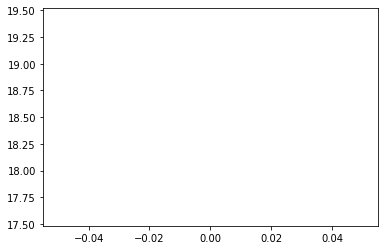

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.76342148e+08 2.18139601e+06 7.76356576e+05 3.52728991e+07] 
UE location : [45 71 51 90 34 34 95 22]
UE ID: 1 Speed: 8.5776686668396 Angle: 3.20205456626543 Ratio: 0.7125958
Reward 18.95775258588803

Battery : 50000000 
UAV loc : [56.1994995777809, 51.83063286873448] 
Task : 305615047.414112 [2.73342148e+08 0.00000000e+00 0.00000000e+00 3.22728991e+07] 
UE location : [45 71 50 90 33 33 95 21]
UE ID: 0 Speed: 45.98333537578583 Angle: 2.5423342204363997 Ratio: 0.08749643
Reward 6.28765836932975

Battery : 50000000 
UAV loc : [22.8571488239254, 23.33737571752863] 
Task : 299327389.0447822 [2.70054490e+08 0.00000000e+00 0.00000000e+00 2.92728991e+07] 
UE location : [44 70 49 89 33 33 94 20]
UE ID: 1 Speed: 44.823089241981506 Angle: 3.1525443626181477 Ratio: 0.3909691
Reward -44.0

Battery : 50000000 
UAV loc : [3.674759418447593, 84.6496099213681] 
Task : 293327389.0447822 [2.67054490e+08 0.00000000e+00 0.00000000e+00 2.62728991e+0

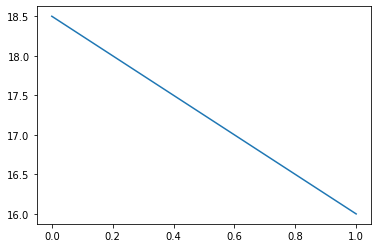

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.39154959e+07 5.87141692e+07 9.31707186e+07 1.48772416e+08] 
UE location : [30 13 51 23 94 57 48 43]
UE ID: 1 Speed: 12.801508605480194 Angle: 1.1586361746244724 Ratio: 0.7343471
Reward 20.29293170434451

Battery : 50000000 
UAV loc : [87.18498512032795, 27.052010413166272] 
Task : 294279868.2956555 [1.09154959e+07 4.74212375e+07 9.01707186e+07 1.45772416e+08] 
UE location : [29 12 50 22 94 57 47 43]
UE ID: 3 Speed: 24.521492421627045 Angle: 1.1786011443027398 Ratio: 0.32874554
Reward 13.469244074272037

Battery : 50000000 
UAV loc : [55.753702743970734, 28.835893378891342] 
Task : 280810624.22138345 [7.91549589e+06 4.44212375e+07 8.71707186e+07 1.41303172e+08] 
UE location : [29 12 49 22 94 56 47 43]
UE ID: 0 Speed: 29.70149517059326 Angle: 5.468754984441883 Ratio: 0.1709714
Reward 12.618692982108026

Battery : 50000000 
UAV loc : [13.732952468308213, 76.70363907811577] 
Task : 268191931.23927543 [4.29680291e+06 4.14212375e+07

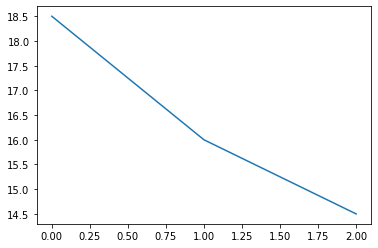

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [6.80884897e+07 1.40704496e+08 1.14694389e+07 9.43103750e+07] 
UE location : [ 8  7 53 40 72 62 27 12]
UE ID: 1 Speed: 16.61505699157715 Angle: 2.1933753126000575 Ratio: 0.51172036
Reward 15.144020250066758

Battery : 50000000 
UAV loc : [31.122514844514626, 50.230535575667545] 
Task : 299428779.74993324 [6.50884897e+07 1.34560476e+08 8.46943894e+06 9.13103750e+07] 
UE location : [ 8  6 53 40 71 62 26 11]
UE ID: 0 Speed: 16.84267520904541 Angle: 3.166219486756244 Ratio: 0.46322936
Reward 14.58897928902912

Battery : 50000000 
UAV loc : [28.494675785606205, 18.420425185109934] 
Task : 284839800.4609041 [5.94995105e+07 1.31560476e+08 5.46943894e+06 8.83103750e+07] 
UE location : [ 7  5 53 39 70 61 25 11]
UE ID: 3 Speed: 0.034974515438079834 Angle: 3.4953684708240322 Ratio: 0.068571925
Reward 12.220860612909794

Battery : 50000000 
UAV loc : [46.18671964333032, 40.83085351351201] 
Task : 272618939.8479943 [5.64995105e+07 1.28560476e

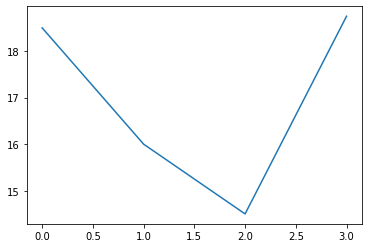

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.40420456e+07 3.18842070e+07 5.82308274e+06 2.62823465e+08] 
UE location : [15 76 28 85 67 61 53 85]
UE ID: 1 Speed: 32.12995529174805 Angle: 5.376014310997725 Ratio: 0.4727233
Reward 14.689612360512733

Battery : 50000000 
UAV loc : [20.86929674219391, 68.9168465023613] 
Task : 299883187.63948727 [1.10420456e+07 2.61945947e+07 2.82308274e+06 2.59823465e+08] 
UE location : [15 75 27 84 67 60 53 84]
UE ID: 1 Speed: 26.931726932525635 Angle: 4.387153220255529 Ratio: 0.2203412
Reward 17.670919792438326

Battery : 50000000 
UAV loc : [26.374291387892868, 60.29959516214376] 
Task : 287212267.84704894 [8.04204562e+06 2.23467576e+07 0.00000000e+00 2.56823465e+08] 
UE location : [15 75 26 84 67 59 53 84]
UE ID: 3 Speed: 1.0488644242286682 Angle: 4.546077524753575 Ratio: 0.8883139
Reward 32.860994502028525

Battery : 50000000 
UAV loc : [20.065625279002575, 73.47971330084988] 
Task : 254351273.3450204 [5.04204562e+06 1.93467576e+07 0.00

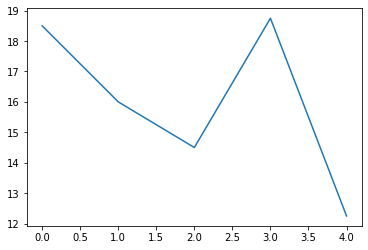

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.82635070e+08 5.33509272e+07 3.68213834e+07 4.17654195e+07] 
UE location : [95 77  5 91 51 41 64 30]
UE ID: 1 Speed: 44.863733649253845 Angle: 0.9621948795531786 Ratio: 0.7761742
Reward 22.403279848017693

Battery : 50000000 
UAV loc : [35.048021171417076, 80.83785513777002] 
Task : 292169520.1519823 [1.79635070e+08 3.99476474e+07 3.38213834e+07 3.87654195e+07] 
UE location : [95 76  4 90 51 40 63 30]
UE ID: 2 Speed: 35.5948269367218 Angle: 3.983834617262546 Ratio: 0.2793393
Reward 13.16284675469035

Battery : 50000000 
UAV loc : [65.07187014225337, 27.9213736247641] 
Task : 279006673.39729196 [1.76635070e+08 3.69476474e+07 2.96585367e+07 3.57654195e+07] 
UE location : [95 75  4 89 51 40 63 30]
UE ID: 3 Speed: 5.657301843166351 Angle: 2.689369050307248 Ratio: 0.43318084
Reward 14.292693341156989

Battery : 50000000 
UAV loc : [1.6746630172576715, 39.3426109659714] 
Task : 264713980.05613497 [1.73635070e+08 3.39476474e+07 2.6658

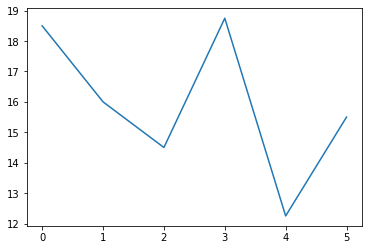

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [5.22482855e+07 6.07381915e+07 1.99212242e+08 2.37408060e+06] 
UE location : [11 23 72 46 67 81 79 63]
UE ID: 0 Speed: 22.325235605239868 Angle: 4.01744849558693 Ratio: 0.16136402
Reward 16.951318002662894

Battery : 50000000 
UAV loc : [29.573528440499786, 85.21693060699818] 
Task : 302621481.9973371 [4.86710480e+07 5.77381915e+07 1.96212242e+08 0.00000000e+00] 
UE location : [11 22 71 45 66 80 78 63]
UE ID: 3 Speed: 5.4777950048446655 Angle: 2.569329248796258 Ratio: 0.7330344
Reward -41.0

Battery : 50000000 
UAV loc : [96.84699018960146, 18.335504917320122] 
Task : 293621481.9973371 [4.56710480e+07 5.47381915e+07 1.93212242e+08 0.00000000e+00] 
UE location : [10 21 70 44 66 80 77 62]
UE ID: 0 Speed: 6.786517798900604 Angle: 1.7721983419629512 Ratio: 0.7017294
Reward 16.057981475375414

Battery : 50000000 
UAV loc : [51.06065701154989, 98.48473564490234] 
Task : 277563500.5219617 [3.56130666e+07 5.17381915e+07 1.90212242e+08 0.

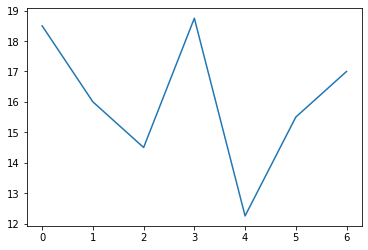

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.08615507e+08 2.45185210e+07 1.08606700e+08 7.28320717e+07] 
UE location : [ 3 26 71 26 25 17 88  4]
UE ID: 0 Speed: 1.7127767205238342 Angle: 6.2008334587002585 Ratio: 0.52802914
Reward 15.356324676949978

Battery : 50000000 
UAV loc : [29.302787554252063, 14.089095319971534] 
Task : 299216475.32305 [1.02259183e+08 2.15185210e+07 1.05606700e+08 6.98320717e+07] 
UE location : [ 2 26 70 25 24 17 88  4]
UE ID: 1 Speed: 2.3912236094474792 Angle: 1.0089670623166156 Ratio: 0.8071635
Reward 24.557218894308328

Battery : 50000000 
UAV loc : [57.6676451222454, 11.274485201866469] 
Task : 274659256.4287417 [9.92591828e+07 5.96130210e+06 1.02606700e+08 6.68320717e+07] 
UE location : [ 1 25 70 25 24 17 88  3]
UE ID: 3 Speed: 19.34329867362976 Angle: 5.339341833773277 Ratio: 0.5974229
Reward 16.451988659371494

Battery : 50000000 
UAV loc : [98.40313455907221, 39.00849035204885] 
Task : 258207267.7693702 [96259182.81465824  2961302.0969607

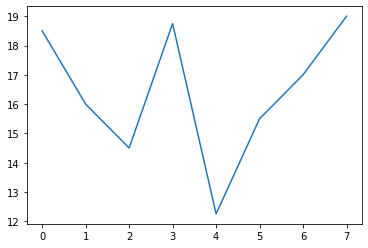

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.46976739e+08 9.30163224e+07 1.93416134e+07 5.52381249e+07] 
UE location : [13 32 65 31 56 62 43 86]
UE ID: 1 Speed: 45.82746624946594 Angle: 4.135470640482994 Ratio: 0.27230194
Reward 13.122588987936735

Battery : 50000000 
UAV loc : [99.63002373499137, 41.01762205043826] 
Task : 301450211.01206326 [1.43976739e+08 8.88937334e+07 1.63416134e+07 5.22381249e+07] 
UE location : [12 31 64 30 56 61 42 85]
UE ID: 0 Speed: 17.62879192829132 Angle: 1.7227046166249136 Ratio: 0.9603332
Reward 38.32258728904581

Battery : 50000000 
UAV loc : [96.23517144169682, 44.34026883790807] 
Task : 263127623.72301745 [1.14654152e+08 8.58937334e+07 1.33416134e+07 4.92381249e+07] 
UE location : [12 30 64 29 56 60 42 85]
UE ID: 3 Speed: 33.14501643180847 Angle: 1.5759847471648594 Ratio: 0.4475416
Reward 14.430273067008018

Battery : 50000000 
UAV loc : [6.320193484310721, 51.51608563304535] 
Task : 248697350.65600944 [1.11654152e+08 8.28937334e+07 1.03

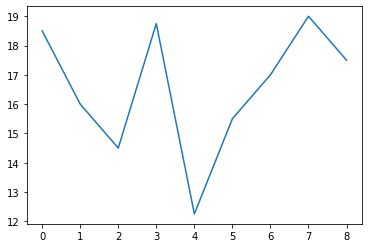

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.21276058e+08 6.19350946e+07 1.15579617e+07 1.98036858e+07] 
UE location : [60 39 47  9 24 12 20 44]
UE ID: 0 Speed: 16.8300062417984 Angle: 1.6624602925327143 Ratio: 0.061340034
Reward 12.196045542253017

Battery : 50000000 
UAV loc : [45.94543511243785, 75.93505006221335] 
Task : 302376754.457747 [2.18080012e+08 5.89350946e+07 8.55796167e+06 1.68036858e+07] 
UE location : [60 38 46  8 24 11 20 44]
UE ID: 3 Speed: 38.36386799812317 Angle: 4.786260117208336 Ratio: 0.15803716
Reward 12.563102601146102

Battery : 50000000 
UAV loc : [77.68408765031722, 32.41907715595573] 
Task : 289813651.8566009 [2.15080012e+08 5.59350946e+07 5.55796167e+06 1.32405832e+07] 
UE location : [59 38 45  8 23 11 20 44]
UE ID: 0 Speed: 0.6705880165100098 Angle: 2.5524912255507175 Ratio: 0.7527605
Reward 21.133984893888353

Battery : 50000000 
UAV loc : [87.34662338604835, 79.16653389744113] 
Task : 268679666.9627125 [2.02946027e+08 5.29350946e+07 2.557

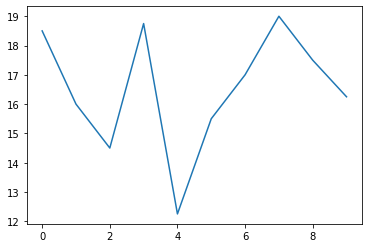

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [8.63962370e+07 6.04965876e+07 5.37926263e+07 1.13887349e+08] 
UE location : [25  6 24 28 26  7 50 72]
UE ID: 1 Speed: 3.4946367144584656 Angle: 2.080731837644328 Ratio: 0.03964007
Reward 12.123828788755059

Battery : 50000000 
UAV loc : [29.41945604995908, 94.99649889530986] 
Task : 302448971.21124494 [8.33962370e+07 5.73727588e+07 5.07926263e+07 1.10887349e+08] 
UE location : [24  6 24 27 26  7 49 71]
UE ID: 3 Speed: 3.9232105016708374 Angle: 1.3982583173113932 Ratio: 0.9800316
Reward 37.83291773258043

Battery : 50000000 
UAV loc : [9.300548113634477, 86.14583781739498] 
Task : 264616053.47866452 [80396236.96733813 54372758.84972588 47792626.31735585 82054431.34424464] 
UE location : [24  5 24 27 25  6 48 71]
UE ID: 2 Speed: 40.50483703613281 Angle: 3.3568963696480614 Ratio: 0.65527475
Reward 17.702582678744616

Battery : 50000000 
UAV loc : [26.90951032180635, 50.77833330062731] 
Task : 246913470.7999199 [77396236.96733813 51

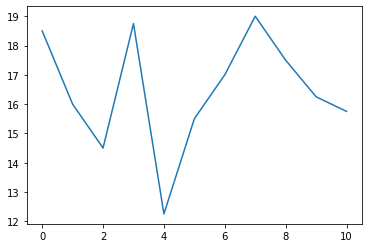

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.48404294e+08 1.39413529e+07 1.32448473e+07 1.38982306e+08] 
UE location : [32 40 33 54 37 93 34 93]
UE ID: 1 Speed: 17.56543219089508 Angle: 6.240290021173032 Ratio: 0.7954522
Reward 27.94135286086762

Battery : 50000000 
UAV loc : [45.0725577806395, 75.32431927830885] 
Task : 291631447.1391324 [1.45404294e+08 0.00000000e+00 1.02448473e+07 1.35982306e+08] 
UE location : [31 40 33 54 36 92 33 92]
UE ID: 1 Speed: 8.768227696418762 Angle: 3.080535274739171 Ratio: 0.39027262
Reward -41.0

Battery : 50000000 
UAV loc : [32.06689991370126, 14.06482998172578] 
Task : 282631447.1391324 [1.42404294e+08 0.00000000e+00 7.24484729e+06 1.32982306e+08] 
UE location : [30 39 33 54 35 92 32 91]
UE ID: 1 Speed: 23.483259975910187 Angle: 3.848663046526916 Ratio: 0.28036773
Reward -41.0

Battery : 50000000 
UAV loc : [21.332328278495538, 80.9886501654006] 
Task : 273631447.1391324 [1.39404294e+08 0.00000000e+00 4.24484729e+06 1.29982306e+08] 
UE

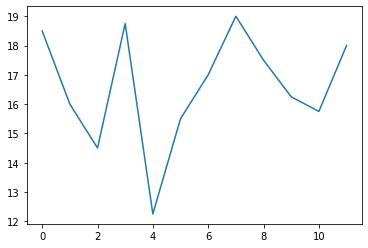

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.17729468e+08 1.15156297e+07 2.06317903e+07 1.64695912e+08] 
UE location : [91 12 76 80 74 57 15 60]
UE ID: 1 Speed: 44.005393981933594 Angle: 3.6744142889381726 Ratio: 0.82922673
Reward 25.515629741609455

Battery : 50000000 
UAV loc : [9.47566393089403, 35.32374673554273] 
Task : 294057170.25839055 [1.14729468e+08 0.00000000e+00 1.76317903e+07 1.61695912e+08] 
UE location : [90 12 76 79 73 57 15 60]
UE ID: 2 Speed: 43.50529909133911 Angle: 6.0500958778406835 Ratio: 0.77477515
Reward 19.320022039640666

Battery : 50000000 
UAV loc : [19.55321145209723, 72.53032096600691] 
Task : 274737148.2187499 [1.11729468e+08 0.00000000e+00 4.31176829e+06 1.58695912e+08] 
UE location : [89 11 76 79 73 57 14 59]
UE ID: 0 Speed: 6.091323494911194 Angle: 1.6017744246541583 Ratio: 0.23512697
Reward 9.922219624638796

Battery : 50000000 
UAV loc : [63.54559842919514, 61.87219480467547] 
Task : 264814928.59411108 [1.07807249e+08 0.00000000e+00 1.

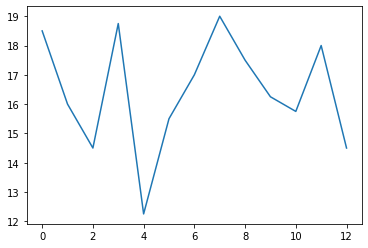

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [5.60637992e+07 4.56996658e+07 3.63702093e+07 1.76439126e+08] 
UE location : [62 91 59  7 14 19 22 33]
UE ID: 3 Speed: 1.0946497321128845 Angle: 3.713469754383645 Ratio: 0.6402854
Reward 17.33994442428428

Battery : 50000000 
UAV loc : [92.04762353684828, 59.24369469713042] 
Task : 297232855.5757157 [5.30637992e+07 4.26996658e+07 3.33702093e+07 1.68099181e+08] 
UE location : [62 90 59  6 14 18 21 32]
UE ID: 0 Speed: 20.27433216571808 Angle: 4.5704908889139 Ratio: 0.35753086
Reward 13.669484996233583

Battery : 50000000 
UAV loc : [81.96208253306168, 82.68671917012966] 
Task : 283563370.57948214 [4.83943142e+07 3.96996658e+07 3.03702093e+07 1.65099181e+08] 
UE location : [62 90 59  6 14 18 21 32]
UE ID: 0 Speed: 25.043809413909912 Angle: 1.7113385155697536 Ratio: 0.91355634
Reward 39.932270533083916

Battery : 50000000 
UAV loc : [45.39462586926106, 51.63985693784525] 
Task : 243631100.04639822 [1.74620437e+07 3.66996658e+07 2.737

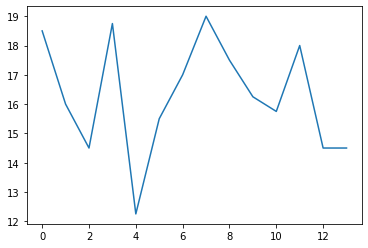

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.10277819e+08 5.69681427e+07 1.03631987e+08 4.36948516e+07] 
UE location : [69 23 10 20 33 30 27 33]
UE ID: 3 Speed: 31.665045022964478 Angle: 0.5314260349074479 Ratio: 0.57422435
Reward 16.045964277164877

Battery : 50000000 
UAV loc : [70.20306280963382, 4.668016995964308] 
Task : 298526835.7228351 [1.07277819e+08 5.39681427e+07 1.00631987e+08 3.66488873e+07] 
UE location : [68 22  9 19 33 29 27 32]
UE ID: 2 Speed: 18.726176023483276 Angle: 2.8863930783145646 Ratio: 0.6658204
Reward 17.977209194230436

Battery : 50000000 
UAV loc : [8.337267613254085, 60.4774744568374] 
Task : 280549626.5286047 [1.04277819e+08 5.09681427e+07 9.16547780e+07 3.36488873e+07] 
UE location : [68 21  9 18 32 28 27 31]
UE ID: 0 Speed: 15.584531426429749 Angle: 4.833486576997092 Ratio: 0.60068893
Reward 16.512939805305837

Battery : 50000000 
UAV loc : [21.99076594814926, 99.29258688722484] 
Task : 264036686.72329885 [96764878.72027262 47968142.70354

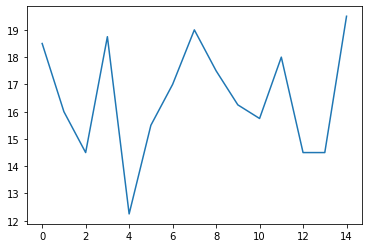

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.56195735e+07 1.29366391e+08 1.53852456e+08 1.57343789e+07] 
UE location : [49 28 30 37 71 99 45  6]
UE ID: 3 Speed: 37.77984976768494 Angle: 5.3931506290913 Ratio: 0.40488076
Reward 14.041006589851142

Battery : 50000000 
UAV loc : [22.192627568256285, 64.1521523931658] 
Task : 300531793.41014886 [1.26195735e+07 1.26366391e+08 1.50852456e+08 1.06933723e+07] 
UE location : [48 28 29 37 71 98 45  6]
UE ID: 0 Speed: 33.77113342285156 Angle: 2.045287368965651 Ratio: 0.1716913
Reward 12.621838083449065

Battery : 50000000 
UAV loc : [76.30770858119718, 19.24324280413998] 
Task : 287909955.3266998 [8.99773540e+06 1.23366391e+08 1.47852456e+08 7.69337232e+06] 
UE location : [47 27 29 37 70 97 45  5]
UE ID: 2 Speed: 20.929306745529175 Angle: 1.5431893539508086 Ratio: 0.55658287
Reward 15.765638456818223

Battery : 50000000 
UAV loc : [88.54299930648608, 16.45744734846062] 
Task : 272144316.8698816 [5.99773540e+06 1.20366391e+08 1.4108

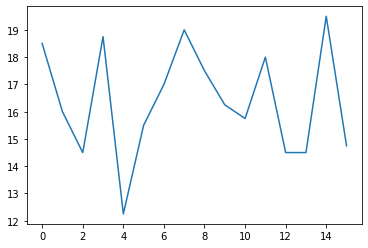

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.19591485e+08 7.65327183e+06 4.89610918e+06 8.24319344e+07] 
UE location : [94 35 14 20 54 45 81 17]
UE ID: 1 Speed: 49.216002225875854 Angle: 2.871177606769101 Ratio: 0.5819715
Reward 16.17654463185519

Battery : 50000000 
UAV loc : [57.25020130111034, 85.2859254135069] 
Task : 298396255.3681448 [2.16591485e+08 4.76727202e+05 1.89610918e+06 7.94319344e+07] 
UE location : [94 34 13 19 53 45 80 16]
UE ID: 0 Speed: 30.076685547828674 Angle: 2.3269589735357274 Ratio: 0.350869
Reward 19.99439967391026

Battery : 50000000 
UAV loc : [61.3536833257001, 83.40587459091466] 
Task : 288401855.69423455 [2.11969921e+08 0.00000000e+00 0.00000000e+00 7.64319344e+07] 
UE location : [94 34 12 18 52 45 79 15]
UE ID: 3 Speed: 17.433035373687744 Angle: 1.6721283787215966 Ratio: 0.8637463
Reward 25.017748357581375

Battery : 50000000 
UAV loc : [40.982030383861456, 74.94837103814689] 
Task : 263384107.33665317 [2.08969921e+08 0.00000000e+00 0.0000

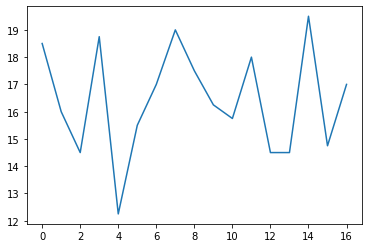

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.03798401e+08 1.69227146e+08 3.87150483e+07 2.83220529e+06] 
UE location : [18 54 38 45 82 68 96 53]
UE ID: 2 Speed: 30.638766288757324 Angle: 6.179628870758344 Ratio: 0.6812646
Reward 23.244400502951382

Battery : 50000000 
UAV loc : [47.46289734954985, 83.28263980511679] 
Task : 296328399.4970486 [1.00798401e+08 1.66227146e+08 2.93028531e+07 0.00000000e+00] 
UE location : [17 53 38 44 81 67 95 53]
UE ID: 0 Speed: 24.065200984477997 Angle: 6.09857019504771 Ratio: 0.1316059
Reward 9.454652648040414

Battery : 50000000 
UAV loc : [88.0842189133773, 86.5034185589252] 
Task : 286873746.8490082 [9.73437479e+07 1.63227146e+08 2.63028531e+07 0.00000000e+00] 
UE location : [17 53 38 43 80 67 94 53]
UE ID: 0 Speed: 17.384645342826843 Angle: 4.056900189468335 Ratio: 0.046268553
Reward 9.145539562520623

Battery : 50000000 
UAV loc : [51.25361143277587, 72.173954007269] 
Task : 277728207.2864876 [9.41982083e+07 1.60227146e+08 2.33028531e

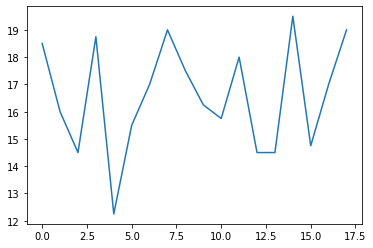

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.49519935e+08 4.82221755e+07 7.13232511e+07 4.55074386e+07] 
UE location : [97 87 41 47 41 92 39 38]
UE ID: 1 Speed: 16.61100685596466 Angle: 6.067105238051668 Ratio: 0.38416713
Reward 13.87145160536325

Battery : 50000000 
UAV loc : [22.472444349693887, 43.85585079215559] 
Task : 300701348.39463675 [1.46519935e+08 4.33507239e+07 6.83232511e+07 4.25074386e+07] 
UE location : [96 86 41 47 40 92 38 37]
UE ID: 3 Speed: 7.780694961547852 Angle: 5.132972357381952 Ratio: 0.21169996
Reward 12.805657564035474

Battery : 50000000 
UAV loc : [35.07519054317072, 75.32363403352065] 
Task : 287895690.8306013 [1.43519935e+08 4.03507239e+07 6.53232511e+07 3.87017810e+07] 
UE location : [96 85 41 46 39 92 37 36]
UE ID: 1 Speed: 1.615092158317566 Angle: 0.882130332749147 Ratio: 0.21382472
Reward 12.815942924218296

Battery : 50000000 
UAV loc : [10.159415802874605, 57.063776216995166] 
Task : 275079747.906383 [1.40519935e+08 3.65347810e+07 6.23

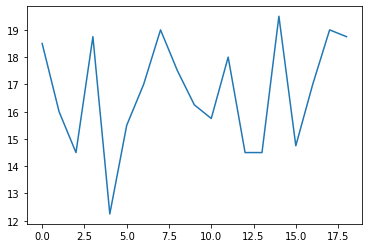

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.43064557e+08 8.47394724e+07 8.25691588e+07 4.19961164e+06] 
UE location : [69 17 89 42 43 81 16 94]
UE ID: 0 Speed: 32.28730857372284 Angle: 5.822851005185313 Ratio: 0.41637748
Reward 14.14030888435459

Battery : 50000000 
UAV loc : [92.63300214588526, 34.35604514514807] 
Task : 300432491.1156454 [1.37924248e+08 8.17394724e+07 7.95691588e+07 1.19961164e+06] 
UE location : [69 16 89 41 43 80 15 94]
UE ID: 1 Speed: 1.408553123474121 Angle: 4.274722839798898 Ratio: 0.36187685
Reward 16.900898499803663

Battery : 50000000 
UAV loc : [3.6019662133412567, 91.97423825156079] 
Task : 288531592.61584175 [1.34924248e+08 7.70381856e+07 7.65691588e+07 0.00000000e+00] 
UE location : [69 16 89 41 42 80 14 93]
UE ID: 1 Speed: 33.07420015335083 Angle: 0.42374590159767767 Ratio: 0.8979546
Reward 35.39867456213003

Battery : 50000000 
UAV loc : [24.907771938086398, 42.6380739096885] 
Task : 253132918.0537117 [1.31924248e+08 4.76395110e+07 7.356

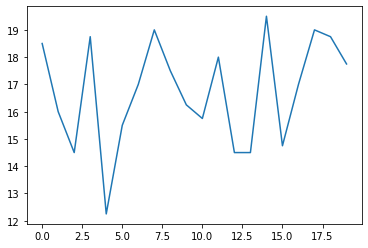

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.39869259e+08 1.29089270e+08 3.49196392e+07 1.06946317e+07] 
UE location : [78 78 67 28 70  9 19 36]
UE ID: 0 Speed: 30.517926812171936 Angle: 5.623943581332713 Ratio: 0.30466437
Reward 13.314463239370943

Battery : 50000000 
UAV loc : [12.310628013841551, 69.27686635829673] 
Task : 301258336.76062906 [1.35554795e+08 1.26089270e+08 3.19196392e+07 7.69463172e+06] 
UE location : [78 77 66 27 70  9 19 36]
UE ID: 1 Speed: 8.382752537727356 Angle: 0.12501288033968463 Ratio: 0.8480661
Reward 28.745427668899655

Battery : 50000000 
UAV loc : [62.796206457784365, 32.20909261467568] 
Task : 272512909.0917294 [1.32554795e+08 1.06343843e+08 2.89196392e+07 4.69463172e+06] 
UE location : [77 77 66 26 70  9 18 36]
UE ID: 0 Speed: 18.11205893754959 Angle: 2.937665712036991 Ratio: 0.45069456
Reward 14.461442372547388

Battery : 50000000 
UAV loc : [94.05499756514928, 12.291744828223727] 
Task : 258051466.719182 [1.27093353e+08 1.03343843e+08 2

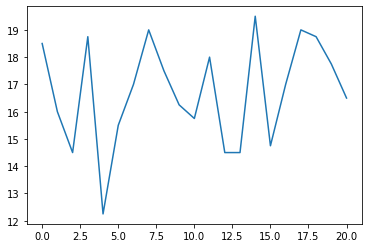

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [4.61873446e+07 1.89065001e+08 3.32037791e+07 4.61166752e+07] 
UE location : [91 32 68 48 25 41 20 40]
UE ID: 3 Speed: 9.278462827205658 Angle: 0.5048401554759993 Ratio: 0.18478999
Reward 12.680033299811065

Battery : 50000000 
UAV loc : [12.099126490807066, 48.76913119246069] 
Task : 301892766.70018893 [4.31873446e+07 1.86065001e+08 3.02037791e+07 4.24366419e+07] 
UE location : [91 32 67 47 25 41 19 40]
UE ID: 1 Speed: 41.68004393577576 Angle: 2.309411072218059 Ratio: 0.2952245
Reward 13.256674569405376

Battery : 50000000 
UAV loc : [3.7440967741702025, 41.256469954561226] 
Task : 288636092.13078356 [4.01873446e+07 1.81808327e+08 2.72037791e+07 3.94366419e+07] 
UE location : [91 32 66 46 24 40 19 39]
UE ID: 0 Speed: 46.911680698394775 Angle: 2.425993612097368 Ratio: 0.58323103
Reward 16.19823266506231

Battery : 50000000 
UAV loc : [33.98342885433294, 3.3799010166092103] 
Task : 272437859.46572125 [3.29891120e+07 1.78808327e+08

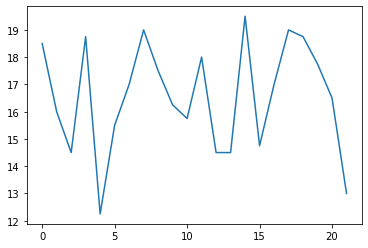

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [6.71567587e+07 1.07152508e+08 6.53606158e+07 7.49029172e+07] 
UE location : [90 69 39 74 63  8 46 47]
UE ID: 1 Speed: 15.043532848358154 Angle: 1.9783543493481497 Ratio: 0.91727686
Reward 39.75359724418408

Battery : 50000000 
UAV loc : [3.721664775366662, 18.866062781000892] 
Task : 274819202.7558159 [64156758.7391279  76398910.99466099 62360615.80983799 71902917.212189  ] 
UE location : [89 69 38 74 62  8 45 47]
UE ID: 2 Speed: 12.079063057899475 Angle: 2.76223650829507 Ratio: 0.54060286
Reward 15.530297551510573

Battery : 50000000 
UAV loc : [50.13836994501446, 66.07887825908279] 
Task : 259288905.20430535 [61156758.7391279  73398910.99466099 55830318.25832746 68902917.212189  ] 
UE location : [88 69 38 73 62  7 44 47]
UE ID: 0 Speed: 49.496397376060486 Angle: 1.2201032641640461 Ratio: 0.45620713
Reward 14.516806389947176

Battery : 50000000 
UAV loc : [85.72036578926827, 56.266937076748036] 
Task : 244772098.81435817 [55639

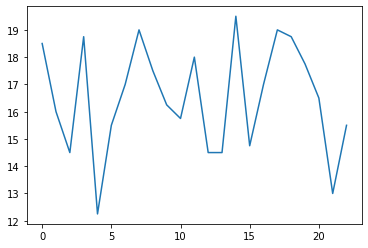

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [5.61968256e+07 7.88130065e+07 1.62866276e+07 1.63276340e+08] 
UE location : [ 2 25 42 31 58  5 11 92]
UE ID: 0 Speed: 45.61992883682251 Angle: 0.16470669301488122 Ratio: 0.8532816
Reward 29.44733551463604

Battery : 50000000 
UAV loc : [99.746895952984, 52.001958369743306] 
Task : 285125464.48536396 [3.57494900e+07 7.58130065e+07 1.32866276e+07 1.60276340e+08] 
UE location : [ 1 24 41 31 58  4 11 91]
UE ID: 1 Speed: 41.64970517158508 Angle: 4.092128193084659 Ratio: 0.40270677
Reward 14.02265865376103

Battery : 50000000 
UAV loc : [46.18864698561538, 11.047279469738669] 
Task : 271102805.83160293 [3.27494900e+07 7.07903479e+07 1.02866276e+07 1.57276340e+08] 
UE location : [ 1 24 40 30 57  3 11 91]
UE ID: 1 Speed: 44.05316710472107 Angle: 4.608181650748275 Ratio: 0.015343517
Reward 12.04674782728076

Battery : 50000000 
UAV loc : [39.371196743411474, 76.69136459845163] 
Task : 259056058.00432217 [2.97494900e+07 6.77436000e+07 7.2

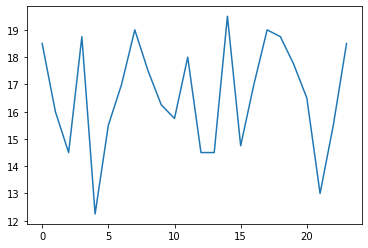

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [7.81158132e+05 2.30498574e+08 2.47515611e+07 5.85415066e+07] 
UE location : [35 40 75 95 46 39 38 96]
UE ID: 2 Speed: 4.755905270576477 Angle: 5.140968831450051 Ratio: 0.58874685
Reward 19.075935007785677

Battery : 50000000 
UAV loc : [2.354319072543376, 32.5766223892515] 
Task : 300496864.9922143 [0.00000000e+00 2.27498574e+08 1.74567842e+07 5.55415066e+07] 
UE location : [35 40 75 94 46 39 38 96]
UE ID: 1 Speed: 48.66933822631836 Angle: 0.5223195220074901 Ratio: 0.39896917
Reward 10.991424511663675

Battery : 50000000 
UAV loc : [53.429807816257835, 85.73524951049194] 
Task : 289505440.48055065 [0.00000000e+00 2.22507150e+08 1.44567842e+07 5.25415066e+07] 
UE location : [35 39 75 93 45 38 37 95]
UE ID: 2 Speed: 9.963358938694 Angle: 0.4474795355016515 Ratio: 0.20883802
Reward 9.791890990583479

Battery : 50000000 
UAV loc : [41.21799757314193, 4.634122025260012] 
Task : 279713549.48996717 [0.00000000e+00 2.19507150e+08 1.0664

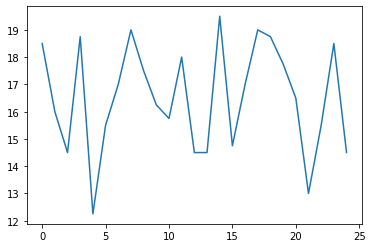

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [6.10054629e+07 7.33280054e+07 2.79976053e+06 1.77439571e+08] 
UE location : [73 88 20 51 33 10 35 82]
UE ID: 0 Speed: 11.637507379055023 Angle: 1.1223758423846604 Ratio: 0.20168582
Reward 17.557679477288247

Battery : 50000000 
UAV loc : [95.46433750360279, 48.694209598261295] 
Task : 302015120.52271175 [5.72475440e+07 7.03280054e+07 0.00000000e+00 1.74439571e+08] 
UE location : [73 87 20 51 33  9 35 82]
UE ID: 3 Speed: 12.068116664886475 Angle: 2.022977610783245 Ratio: 0.030574232
Reward 9.094615493088186

Battery : 50000000 
UAV loc : [19.143183921391937, 45.05655909958932] 
Task : 292920505.02962357 [5.42475440e+07 6.73280054e+07 0.00000000e+00 1.71344956e+08] 
UE location : [73 87 20 50 32  9 34 81]
UE ID: 3 Speed: 49.88502860069275 Angle: 1.1744561005135996 Ratio: 0.8890929
Reward 33.049671308617356

Battery : 50000000 
UAV loc : [40.104315750659225, 92.54994413022928] 
Task : 259870833.7210062 [5.12475440e+07 6.43280054e+0

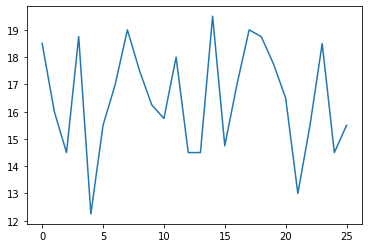

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.93109140e+07 2.36143827e+07 2.13841054e+08 5.78064491e+07] 
UE location : [45  8 93 81 44 75 37 96]
UE ID: 0 Speed: 7.899317145347595 Angle: 1.0027972462790127 Ratio: 0.41027838
Reward 14.087146032696724

Battery : 50000000 
UAV loc : [24.94091697433305, 65.89588578758594] 
Task : 300485653.9673033 [1.42237680e+07 2.06143827e+07 2.10841054e+08 5.48064491e+07] 
UE location : [45  8 92 80 43 74 36 95]
UE ID: 0 Speed: 7.658137381076813 Angle: 3.4030461217304766 Ratio: 0.23956859
Reward 12.945128995145142

Battery : 50000000 
UAV loc : [45.69608983311184, 8.362706374691697] 
Task : 287540524.97215813 [1.02786390e+07 1.76143827e+07 2.07841054e+08 5.18064491e+07] 
UE location : [45  7 91 80 42 74 35 95]
UE ID: 1 Speed: 30.434846878051758 Angle: 4.471635639218812 Ratio: 0.83006275
Reward 31.61438271512383

Battery : 50000000 
UAV loc : [43.93781850636458, 80.56422351744175] 
Task : 260926142.2570343 [7.27863898e+06 0.00000000e+00 2.0

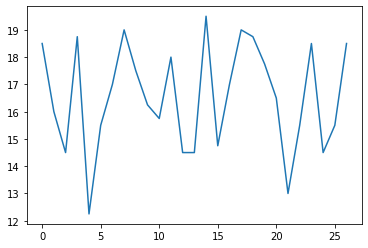

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.67050457e+07 2.32387396e+08 1.11057435e+06 6.43697845e+07] 
UE location : [76 20 84 84 29 46 89 54]
UE ID: 1 Speed: 15.769033133983612 Angle: 0.1332642064405368 Ratio: 0.17294618
Reward 15.737907835520387

Battery : 50000000 
UAV loc : [37.078364009801135, 9.523315076052086] 
Task : 303834892.1644796 [1.37050457e+07 2.28760062e+08 0.00000000e+00 6.13697845e+07] 
UE location : [75 20 83 83 28 45 88 54]
UE ID: 1 Speed: 49.521613121032715 Angle: 5.2887837594608325 Ratio: 0.2143757
Reward 9.818619176222683

Battery : 50000000 
UAV loc : [6.78783477211482, 0.2762551881005493] 
Task : 294016272.98825693 [1.07050457e+07 2.24941443e+08 0.00000000e+00 5.83697845e+07] 
UE location : [75 19 82 82 27 44 87 54]
UE ID: 3 Speed: 25.769612193107605 Angle: 1.5576775328473282 Ratio: 0.47269136
Reward 11.689267643527806

Battery : 50000000 
UAV loc : [87.41086923532464, 4.36499023890633] 
Task : 282327005.3447291 [7.70504566e+06 2.21941443e+08 0

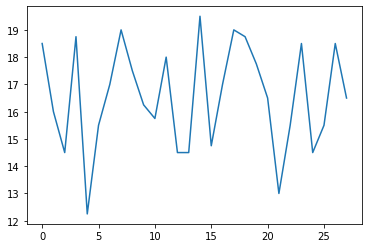

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [8.47819956e+07 1.17504194e+08 9.51781003e+07 1.71085103e+07] 
UE location : [69 48 64 19 72 10  7 59]
UE ID: 3 Speed: 34.012117981910706 Angle: 0.8793722757392877 Ratio: 0.593218
Reward 16.3749581115216

Battery : 50000000 
UAV loc : [31.26889282779075, 20.085319400448043] 
Task : 298197841.8884784 [8.17819956e+07 1.14504194e+08 9.21781003e+07 9.73355217e+06] 
UE location : [68 47 63 18 72  9  7 58]
UE ID: 1 Speed: 49.954867362976074 Angle: 3.5584459405852633 Ratio: 0.9214041
Reward 39.69776215888244

Battery : 50000000 
UAV loc : [40.82154899816999, 14.066757124297169] 
Task : 258500079.72959596 [78781995.64537477 83806431.57717638 89178100.33496362  6733552.17208117] 
UE location : [67 46 63 17 71  8  7 58]
UE ID: 1 Speed: 1.9038408994674683 Angle: 3.122218843255685 Ratio: 0.7577982
Reward 21.38636515767798

Battery : 50000000 
UAV loc : [91.80653856576555, 10.3639469424337] 
Task : 237113714.57191798 [75781995.64537477 714200

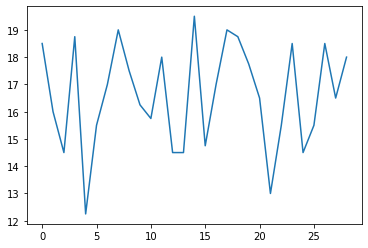

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [3.83466826e+07 2.32064306e+08 1.83850978e+06 4.23233018e+07] 
UE location : [96 21 71 12 76 18 93 91]
UE ID: 3 Speed: 16.975019872188568 Angle: 6.056787569422212 Ratio: 0.48074675
Reward 18.61603737295586

Battery : 50000000 
UAV loc : [54.183961541355075, 18.964020082975708] 
Task : 300956762.62704414 [3.53466826e+07 2.29064306e+08 0.00000000e+00 3.65457742e+07] 
UE location : [95 20 71 11 76 18 92 91]
UE ID: 0 Speed: 25.847527384757996 Angle: 0.986696440118666 Ratio: 0.26641542
Reward 10.089507972654403

Battery : 50000000 
UAV loc : [43.75475201528616, 52.62546297668678] 
Task : 290867254.65438974 [3.12571747e+07 2.26064306e+08 0.00000000e+00 3.35457742e+07] 
UE location : [94 20 71 11 76 18 92 91]
UE ID: 2 Speed: 37.09021806716919 Angle: 4.440055708565084 Ratio: 0.9632733
Reward -41.0

Battery : 50000000 
UAV loc : [22.17543687656587, 90.2170902199316] 
Task : 281867254.65438974 [2.82571747e+07 2.23064306e+08 0.00000000e+00 

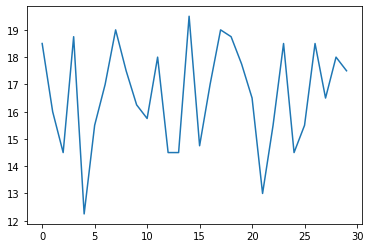

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.40997927e+08 5.42428270e+07 7.89071326e+07 4.04249131e+07] 
UE location : [10 39 26 31 70  2 67 26]
UE ID: 0 Speed: 3.613157570362091 Angle: 5.419821147111143 Ratio: 0.24802354
Reward 12.989486584631324

Battery : 50000000 
UAV loc : [34.813429632788484, 74.61196176921305] 
Task : 301583313.4153687 [1.37008441e+08 5.12428270e+07 7.59071326e+07 3.74249131e+07] 
UE location : [ 9 39 26 31 70  1 67 25]
UE ID: 1 Speed: 25.695565342903137 Angle: 5.469684885393133 Ratio: 0.6871534
Reward 18.58936421339023

Battery : 50000000 
UAV loc : [46.522702126841864, 6.0909655596191214] 
Task : 282993949.20197845 [1.34008441e+08 4.16534628e+07 7.29071326e+07 3.44249131e+07] 
UE location : [ 9 38 26 30 70  0 67 25]
UE ID: 1 Speed: 7.46808797121048 Angle: 5.237325744759401 Ratio: 0.7989031
Reward 23.91818180201462

Battery : 50000000 
UAV loc : [26.539628202687027, 37.15864445416628] 
Task : 259075767.39996383 [1.31008441e+08 2.67352810e+07 6.99

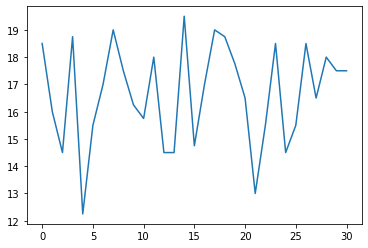

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [4.80518954e+07 1.89379813e+08 6.33601006e+07 1.37809912e+07] 
UE location : [70 88 99 84 50 87 84 83]
UE ID: 1 Speed: 21.803009510040283 Angle: 2.237589237853229 Ratio: 0.17041245
Reward 12.616254853053809

Battery : 50000000 
UAV loc : [51.551424967811954, 86.69947836267511] 
Task : 301956545.1469462 [4.50518954e+07 1.85763558e+08 6.03601006e+07 1.07809912e+07] 
UE location : [69 87 98 83 49 86 83 82]
UE ID: 1 Speed: 5.849330127239227 Angle: 5.9565275438639995 Ratio: 0.13193545
Reward 12.455964180547

Battery : 50000000 
UAV loc : [90.85569783972005, 82.2549248110704] 
Task : 289500580.9663992 [4.20518954e+07 1.82307594e+08 5.73601006e+07 7.78099122e+06] 
UE location : [69 87 98 82 49 85 83 81]
UE ID: 0 Speed: 6.569182872772217 Angle: 3.61692970713746 Ratio: 0.95712876
Reward 38.540353660381705

Battery : 50000000 
UAV loc : [98.52157208109702, 75.13839545637211] 
Task : 250960227.3060175 [1.25115417e+07 1.79307594e+08 5.436010

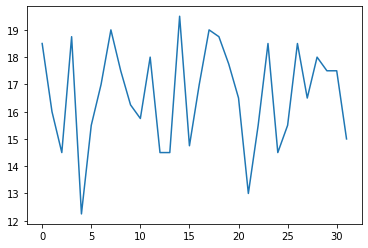

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.02324062e+08 3.66415345e+06 3.74783451e+07 1.71106239e+08] 
UE location : [90 41 62 44 90 29 39 85]
UE ID: 0 Speed: 17.834249138832092 Angle: 1.2433013530175618 Ratio: 0.24329713
Reward 12.964568020579218

Battery : 50000000 
UAV loc : [26.321867728515258, 88.63786052925775] 
Task : 301608231.9794208 [9.83594944e+07 6.64153447e+05 3.44783451e+07 1.68106239e+08] 
UE location : [90 41 62 43 90 28 38 84]
UE ID: 0 Speed: 0.07396936416625977 Angle: 0.21421802018324873 Ratio: 0.54416496
Reward 18.245481576941373

Battery : 50000000 
UAV loc : [39.41463696630194, 65.35851872506555] 
Task : 288362750.4024794 [9.17781663e+07 0.00000000e+00 3.14783451e+07 1.65106239e+08] 
UE location : [89 40 61 43 90 28 37 83]
UE ID: 3 Speed: 8.109150826931 Angle: 2.307492098205089 Ratio: 0.11390117
Reward 9.385626853377461

Battery : 50000000 
UAV loc : [3.3448709884822847, 63.50938749372972] 
Task : 278977123.54910195 [8.87781663e+07 0.00000000e+00 2

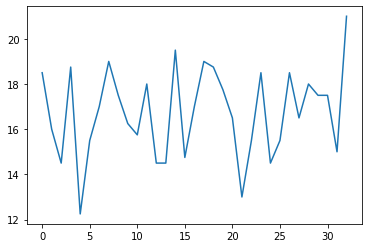

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [3.65706886e+07 6.48627636e+07 2.12604655e+08 5.34692676e+05] 
UE location : [91 40 83 81 46  7 49 77]
UE ID: 3 Speed: 29.17497456073761 Angle: 0.6016749397534501 Ratio: 0.11217213
Reward 14.534692675848722

Battery : 50000000 
UAV loc : [5.151980343015339, 51.37377890317225] 
Task : 305038107.3241513 [3.35706886e+07 6.18627636e+07 2.09604655e+08 0.00000000e+00] 
UE location : [91 39 82 80 46  6 48 77]
UE ID: 3 Speed: 17.261993885040283 Angle: 6.185361449840415 Ratio: 0.5158173
Reward -41.0

Battery : 50000000 
UAV loc : [33.14456864623878, 31.216397856189815] 
Task : 296038107.3241513 [3.05706886e+07 5.88627636e+07 2.06604655e+08 0.00000000e+00] 
UE location : [90 38 82 79 45  5 47 76]
UE ID: 2 Speed: 29.74655330181122 Angle: 0.7416439455215056 Ratio: 0.04932508
Reward 9.155652823973835

Battery : 50000000 
UAV loc : [92.15405123198082, 68.97755820716611] 
Task : 286882454.50017744 [2.75706886e+07 5.58627636e+07 2.03449002e+08 0

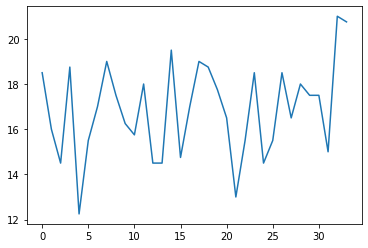

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.04837158e+08 8.13633229e+07 4.16954243e+07 8.66768952e+07] 
UE location : [ 7 20 81 68 51 41 35 89]
UE ID: 0 Speed: 12.507210671901703 Angle: 5.979988911158404 Ratio: 0.82025
Reward 25.689844663188218

Battery : 50000000 
UAV loc : [6.328059322140689, 26.569302344228163] 
Task : 288882955.3368118 [88147312.93048595 78363322.89744708 38695424.29234757 83676895.2165312 ] 
UE location : [ 6 20 81 68 50 41 34 89]
UE ID: 0 Speed: 46.08905911445618 Angle: 1.7698344536003696 Ratio: 0.074968934
Reward 12.243134323222577

Battery : 50000000 
UAV loc : [78.49708345830777, 25.156473560082304] 
Task : 276639821.0135892 [84904178.60726333 75363322.89744708 35695424.29234757 80676895.2165312 ] 
UE location : [ 5 19 81 67 49 41 34 88]
UE ID: 1 Speed: 10.311752557754517 Angle: 3.5157060749954505 Ratio: 0.64379406
Reward 17.422094246725024

Battery : 50000000 
UAV loc : [89.85743504291577, 61.19297779812598] 
Task : 259217726.76686418 [8190417

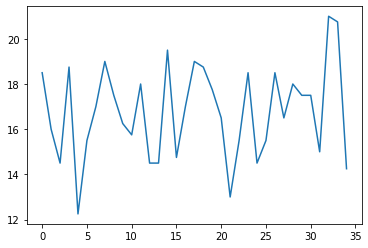

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.03476967e+08 3.70425933e+06 1.65904076e+08 4.14874976e+07] 
UE location : [31 37 77 20 77 77 48 93]
UE ID: 3 Speed: 34.95413661003113 Angle: 6.12914719587967 Ratio: 0.61505514
Reward 16.793324035741268

Battery : 50000000 
UAV loc : [54.02646077253621, 63.69983236035068] 
Task : 297779475.96425873 [1.00476967e+08 7.04259332e+05 1.62904076e+08 3.36941735e+07] 
UE location : [31 36 76 20 77 76 48 92]
UE ID: 2 Speed: 38.65689933300018 Angle: 2.162135059820991 Ratio: 0.031751156
Reward 14.802636384824693

Battery : 50000000 
UAV loc : [47.628576886467044, 20.739861993337172] 
Task : 287976839.57943404 [9.74769673e+07 0.00000000e+00 1.59805699e+08 3.06941735e+07] 
UE location : [31 35 76 19 76 75 47 92]
UE ID: 3 Speed: 36.832982301712036 Angle: 4.198699785590684 Ratio: 0.31298292
Reward 10.36670364318472

Battery : 50000000 
UAV loc : [47.09164322167112, 66.06330929232058] 
Task : 277610135.9362493 [9.44769673e+07 0.00000000e+00 1.

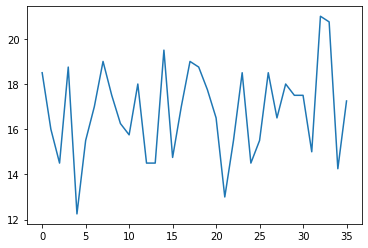

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.82380762e+08 2.77501646e+07 3.27122828e+07 7.17295903e+07] 
UE location : [51 40 35 42 48 95 29 55]
UE ID: 0 Speed: 19.230473041534424 Angle: 2.629549229931618 Ratio: 0.64641744
Reward 17.484581341848315

Battery : 50000000 
UAV loc : [76.4071284968054, 57.78448668209535] 
Task : 297088218.6581517 [1.73896181e+08 2.47501646e+07 2.97122828e+07 6.87295903e+07] 
UE location : [50 39 34 41 48 95 29 55]
UE ID: 1 Speed: 12.64365017414093 Angle: 4.347517268916204 Ratio: 0.7785437
Reward 22.546691356562675

Battery : 50000000 
UAV loc : [10.449829360464946, 2.682626059262816] 
Task : 274541527.301589 [1.70896181e+08 1.12034732e+07 2.67122828e+07 6.57295903e+07] 
UE location : [49 39 34 40 48 94 28 54]
UE ID: 0 Speed: 24.922749400138855 Angle: 5.955475179114497 Ratio: 0.50347924
Reward 15.042043466715693

Battery : 50000000 
UAV loc : [4.623688293986561, 66.05945400396251] 
Task : 259499483.83487332 [1.64854138e+08 8.20347322e+06 2.371

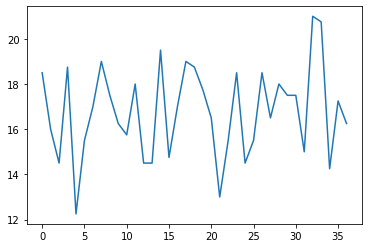

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.30168447e+07 1.82316088e+08 9.92773875e+06 9.93121284e+07] 
UE location : [35 71  2  5 16 53 79 72]
UE ID: 2 Speed: 20.442843437194824 Angle: 3.5781921981590084 Ratio: 0.3621729
Reward 13.70346902423644

Battery : 50000000 
UAV loc : [52.51987825576521, 64.44697850350849] 
Task : 300869330.97576356 [2.00168447e+07 1.79316088e+08 5.22426973e+06 9.63121284e+07] 
UE location : [34 70  2  4 16 52 78 71]
UE ID: 0 Speed: 4.818500578403473 Angle: 5.729866153158707 Ratio: 0.11487877
Reward 12.38936623687613

Battery : 50000000 
UAV loc : [61.93860284383277, 8.521103242031813] 
Task : 288479964.7388874 [1.66274784e+07 1.76316088e+08 2.22426973e+06 9.33121284e+07] 
UE location : [34 69  1  4 16 52 77 71]
UE ID: 1 Speed: 21.28116488456726 Angle: 0.7703502837471458 Ratio: 0.5865931
Reward 20.481042505477546

Battery : 50000000 
UAV loc : [78.86120636443366, 65.89772453072271] 
Task : 272998922.2334099 [1.36274784e+07 1.69059315e+08 0.0000

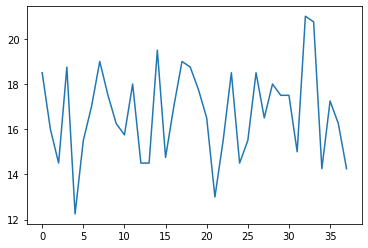

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [3.74418001e+07 6.77438393e+07 1.64934760e+08 4.44524001e+07] 
UE location : [32 31 15 72 18 41 57 56]
UE ID: 1 Speed: 21.01672887802124 Angle: 2.777384755828955 Ratio: 0.38532555
Reward 13.880632349436045

Battery : 50000000 
UAV loc : [36.183805561725535, 51.36465366342122] 
Task : 300692167.65056396 [3.44418001e+07 6.28632070e+07 1.61934760e+08 4.14524001e+07] 
UE location : [31 31 14 72 17 40 57 55]
UE ID: 0 Speed: 24.215909838676453 Angle: 2.2519248051357192 Ratio: 0.88082135
Reward 34.17229327937281

Battery : 50000000 
UAV loc : [93.57712542171726, 17.708941937678446] 
Task : 266519874.37119114 [9.26950684e+06 5.98632070e+07 1.58934760e+08 3.84524001e+07] 
UE location : [31 31 13 71 16 39 56 54]
UE ID: 1 Speed: 11.366067826747894 Angle: 5.107156464400672 Ratio: 0.6653925
Reward 17.96572898626989

Battery : 50000000 
UAV loc : [5.155801055610709, 78.2916301306301] 
Task : 248554145.38492125 [6.26950684e+06 5.08974780e+07 1.

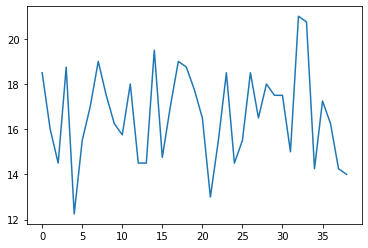

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.64165449e+07 1.10034363e+08 5.78529257e+07 1.20268966e+08] 
UE location : [44 71  1  7 26 49 93 68]
UE ID: 1 Speed: 3.177398443222046 Angle: 6.18144560435259 Ratio: 0.16968179
Reward 12.613072620597183

Battery : 50000000 
UAV loc : [83.90319503257899, 32.27101732649942] 
Task : 301959727.3794028 [2.34165449e+07 1.06421291e+08 5.48529257e+07 1.17268966e+08] 
UE location : [44 70  1  6 26 49 93 68]
UE ID: 2 Speed: 23.413193225860596 Angle: 2.4923991385655193 Ratio: 0.06609568
Reward 12.212320508373738

Battery : 50000000 
UAV loc : [74.70900689329483, 42.53270116732892] 
Task : 289747406.8710291 [2.04165449e+07 1.03421291e+08 5.16406052e+07 1.14268966e+08] 
UE location : [44 70  1  5 26 49 93 67]
UE ID: 2 Speed: 36.03696823120117 Angle: 5.213483503817223 Ratio: 0.3836732
Reward 13.867547470815003

Battery : 50000000 
UAV loc : [2.0654199176476595, 92.62153320867696] 
Task : 275879859.4002141 [1.74165449e+07 1.00421291e+08 4.677

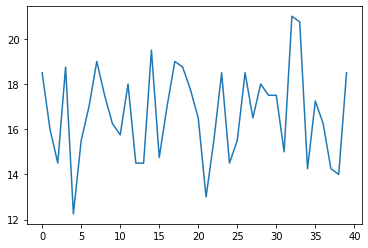

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.47555312e+07 3.82750300e+07 7.03605809e+07 1.81181658e+08] 
UE location : [37 15 33 40 55 63 55 73]
UE ID: 2 Speed: 21.22468799352646 Angle: 3.084783495214606 Ratio: 0.87979615
Reward 33.957602720502855

Battery : 50000000 
UAV loc : [80.95518071119727, 79.48917861555174] 
Task : 280615197.27949715 [2.17555312e+07 3.52750300e+07 4.54029782e+07 1.78181658e+08] 
UE location : [37 15 32 40 54 62 55 72]
UE ID: 2 Speed: 21.71550691127777 Angle: 2.6115479878562016 Ratio: 0.4749306
Reward 14.713530594852388

Battery : 50000000 
UAV loc : [21.937816355114137, 46.79282396833173] 
Task : 265901666.68464476 [1.87555312e+07 3.22750300e+07 3.96894476e+07 1.75181658e+08] 
UE location : [37 14 31 39 53 61 54 71]
UE ID: 2 Speed: 44.66698169708252 Angle: 6.172328230748811 Ratio: 0.8370179
Reward 27.40692864869845

Battery : 50000000 
UAV loc : [33.06162395995216, 14.86912186870768] 
Task : 238494738.0359463 [1.57555312e+07 2.92750300e+07 2.128

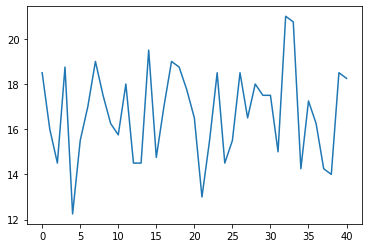

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.32638951e+08 6.15091716e+07 7.90416656e+06 1.25205108e+07] 
UE location : [51 56 77 11 84 74 11  2]
UE ID: 3 Speed: 35.731637477874756 Angle: 6.114306605869528 Ratio: 0.08350274
Reward 12.273332207139253

Battery : 50000000 
UAV loc : [77.66861129284734, 0.5670292573142888] 
Task : 302299467.79286075 [2.29638951e+08 5.85091716e+07 4.90416656e+06 9.24717861e+06] 
UE location : [51 55 77 10 83 74 11  2]
UE ID: 1 Speed: 28.887853026390076 Angle: 5.171030510611081 Ratio: 0.23297125
Reward 12.911196293429434

Battery : 50000000 
UAV loc : [45.81431006947696, 66.45983171424064] 
Task : 289388271.4994313 [2.26638951e+08 5.45979753e+07 1.90416656e+06 6.24717861e+06] 
UE location : [51 55 77  9 83 73 10  2]
UE ID: 2 Speed: 20.24826556444168 Angle: 3.5024133225332403 Ratio: 0.21100423
Reward 15.90416656317079

Battery : 50000000 
UAV loc : [86.98828077179712, 68.86600212289977] 
Task : 278484104.9362605 [2.23638951e+08 5.15979753e+07 0.

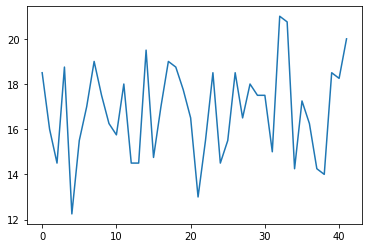

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [8.25698192e+07 1.96491213e+06 1.35197000e+08 9.48410685e+07] 
UE location : [53 64 90 18  2 10 89 88]
UE ID: 0 Speed: 25.949355959892273 Angle: 5.283148177699089 Ratio: 0.03292963
Reward 16.067064864998223

Battery : 50000000 
UAV loc : [1.9686105656319342, 16.384932658542084] 
Task : 303505735.1350018 [7.94676665e+07 0.00000000e+00 1.32197000e+08 9.18410685e+07] 
UE location : [52 63 90 18  1 10 88 88]
UE ID: 1 Speed: 39.24257159233093 Angle: 2.601314583308112 Ratio: 0.15057331
Reward -41.0

Battery : 50000000 
UAV loc : [31.552788420952993, 57.03098216412741] 
Task : 294505735.1350018 [7.64676665e+07 0.00000000e+00 1.29197000e+08 8.88410685e+07] 
UE location : [52 63 90 18  1 10 88 87]
UE ID: 0 Speed: 24.480339884757996 Angle: 3.5246575419856954 Ratio: 0.65360326
Reward 14.66058948240006

Battery : 50000000 
UAV loc : [84.66992168677905, 11.891149259881217] 
Task : 279845145.6526017 [6.78070770e+07 0.00000000e+00 1.26197000e+0

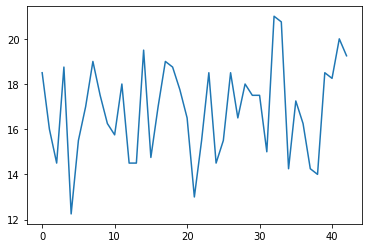

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.03050194e+08 5.93361365e+06 4.05166533e+07 1.65072339e+08] 
UE location : [21 37 17 73 24 26 56 16]
UE ID: 0 Speed: 12.759736180305481 Angle: 1.9897955390624822 Ratio: 0.9549721
Reward 38.55293172248256

Battery : 50000000 
UAV loc : [80.87467494893303, 34.40248335860474] 
Task : 276019868.27751744 [7.34972621e+07 2.93361365e+06 3.75166533e+07 1.62072339e+08] 
UE location : [20 37 17 72 24 25 56 15]
UE ID: 2 Speed: 21.269920468330383 Angle: 1.755032437814141 Ratio: 0.23172453
Reward 17.838463040506245

Battery : 50000000 
UAV loc : [97.81185588378207, 68.75581280957022] 
Task : 263181405.2370112 [7.04972621e+07 0.00000000e+00 3.36118039e+07 1.59072339e+08] 
UE location : [20 36 16 71 23 25 56 14]
UE ID: 0 Speed: 17.824596166610718 Angle: 3.2764706108152417 Ratio: 0.22017825
Reward 9.84703297455877

Battery : 50000000 
UAV loc : [14.914716283487905, 35.895045604877396] 
Task : 253334372.26245242 [6.66502292e+07 0.00000000e+00 3

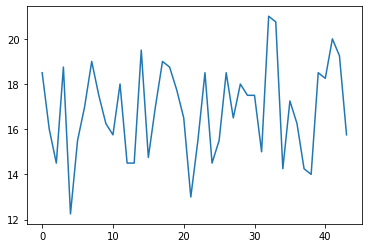

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [3.92695935e+07 2.84981557e+07 1.11522614e+08 1.35282437e+08] 
UE location : [ 9  6 72 61 68 76 70  7]
UE ID: 2 Speed: 17.20215678215027 Angle: 3.7086442313240973 Ratio: 0.82679766
Reward 26.320782572277427

Battery : 50000000 
UAV loc : [50.98192982507044, 75.99057423752811] 
Task : 288252017.4277226 [3.62695935e+07 2.54981557e+07 9.42018314e+07 1.32282437e+08] 
UE location : [ 9  5 71 61 68 75 70  7]
UE ID: 3 Speed: 35.330963134765625 Angle: 5.850511345280932 Ratio: 0.029072016
Reward 12.089827516471743

Battery : 50000000 
UAV loc : [94.29328523599452, 82.36932694554753] 
Task : 276162189.9112508 [3.32695935e+07 2.24981557e+07 9.12018314e+07 1.29192609e+08] 
UE location : [ 8  4 70 60 68 75 70  7]
UE ID: 3 Speed: 17.570289969444275 Angle: 4.05582872486039 Ratio: 0.56259644
Reward 15.858654744744598

Battery : 50000000 
UAV loc : [43.154699875242386, 45.19614208913936] 
Task : 260303535.16650623 [3.02695935e+07 1.94981557e+07 8

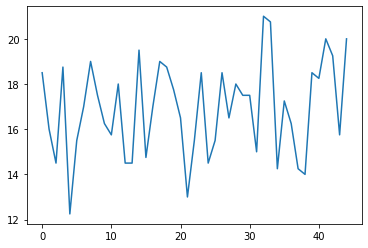

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.16575185e+08 8.81090421e+07 4.43621345e+07 6.55264383e+07] 
UE location : [69 53 90 47 96 37 22 72]
UE ID: 3 Speed: 3.700365126132965 Angle: 3.72918481830485 Ratio: 0.3277871
Reward 13.462871815852344

Battery : 50000000 
UAV loc : [92.02679030202603, 5.132939274361092] 
Task : 301109928.18414766 [1.13575185e+08 8.51090421e+07 4.13621345e+07 6.10635665e+07] 
UE location : [68 52 90 46 96 37 21 71]
UE ID: 0 Speed: 1.525910198688507 Angle: 3.266312482179839 Ratio: 0.73525727
Reward 20.331755840064705

Battery : 50000000 
UAV loc : [51.27325214135681, 94.31210154174039] 
Task : 280778172.34408295 [1.02243429e+08 8.21090421e+07 3.83621345e+07 5.80635665e+07] 
UE location : [67 52 89 46 96 37 21 71]
UE ID: 3 Speed: 27.71952748298645 Angle: 5.2816336712766745 Ratio: 0.951387
Reward 38.72712483086964

Battery : 50000000 
UAV loc : [21.39665597233602, 96.37128061369253] 
Task : 242051047.5132133 [99243429.21468525 79109042.08554432 35

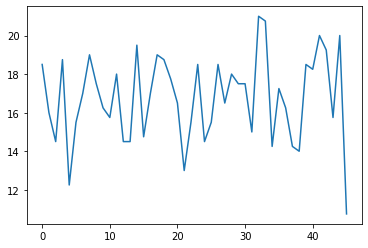

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.88451166e+07 1.01617715e+08 9.54402641e+07 8.86697044e+07] 
UE location : [77 47 29 60 71 54 33  8]
UE ID: 2 Speed: 4.244062304496765 Angle: 5.183594472396235 Ratio: 0.39791113
Reward 13.982653153654873

Battery : 50000000 
UAV loc : [7.336235899410326, 21.84484342125188] 
Task : 300590146.8463451 [25845116.58392116 98617714.93859994 90457610.96980615 85669704.35401787] 
UE location : [77 46 28 60 71 53 32  7]
UE ID: 2 Speed: 2.817101776599884 Angle: 3.512161365972663 Ratio: 0.7608657
Reward 21.545251156029583

Battery : 50000000 
UAV loc : [71.03546539987917, 82.46424093340181] 
Task : 279044895.69031554 [22845116.58392116 95617714.93859994 77912359.81377655 82669704.35401787] 
UE location : [76 45 27 60 71 53 32  6]
UE ID: 0 Speed: 10.433278977870941 Angle: 4.429817060918598 Ratio: 0.22532403
Reward 12.872586906453014

Battery : 50000000 
UAV loc : [12.639085356647684, 44.47301911509953] 
Task : 266172308.78386253 [18972529.

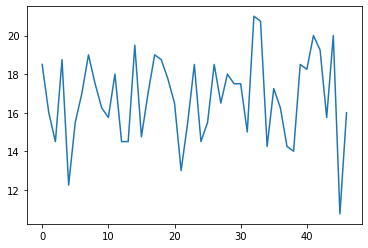

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [6.00350244e+07 1.06608836e+08 1.44980718e+08 2.94822197e+06] 
UE location : [79  4 87 25  4 19 71 31]
UE ID: 1 Speed: 48.92413020133972 Angle: 6.072158086877389 Ratio: 0.80350316
Reward 29.21564272972572

Battery : 50000000 
UAV loc : [16.11897616139686, 24.786567697546502] 
Task : 290357157.2702743 [5.70350244e+07 9.13414148e+07 1.41980718e+08 0.00000000e+00] 
UE location : [79  3 87 25  3 18 70 31]
UE ID: 3 Speed: 33.99355411529541 Angle: 1.6469669367722581 Ratio: 0.35145625
Reward -41.0

Battery : 50000000 
UAV loc : [46.78304710686234, 68.15548318669471] 
Task : 281357157.2702743 [5.40350244e+07 8.83414148e+07 1.38980718e+08 0.00000000e+00] 
UE location : [78  3 87 25  2 17 69 30]
UE ID: 1 Speed: 17.366966605186462 Angle: 5.671241946470901 Ratio: 0.49071255
Reward 11.890583047391534

Battery : 50000000 
UAV loc : [99.84855555514969, 17.886859169345826] 
Task : 269466574.22288275 [5.10350244e+07 8.24508317e+07 1.35980718e+08 

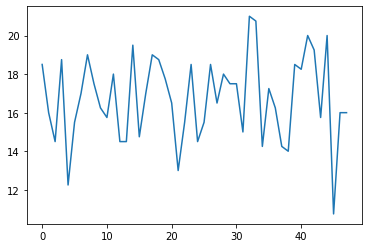

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [5.89144860e+07 2.24137927e+07 1.04863870e+08 1.28380651e+08] 
UE location : [22 86 13 77 34 30 35 77]
UE ID: 1 Speed: 23.345373570919037 Angle: 2.327885503923723 Ratio: 0.20373237
Reward 12.767577497796655

Battery : 50000000 
UAV loc : [3.3804745895110955, 96.83108333233008] 
Task : 301805222.50220335 [5.59144860e+07 1.86462152e+07 1.01863870e+08 1.25380651e+08] 
UE location : [22 85 13 77 34 30 35 76]
UE ID: 2 Speed: 32.45948553085327 Angle: 6.189739437001153 Ratio: 0.59615606
Reward 16.428612164312003

Battery : 50000000 
UAV loc : [30.165701731345962, 19.770907539037808] 
Task : 285376610.33789134 [5.29144860e+07 1.56462152e+07 9.44352583e+07 1.22380651e+08] 
UE location : [22 84 13 77 33 29 34 76]
UE ID: 0 Speed: 3.393930196762085 Angle: 3.7625533945257024 Ratio: 0.20880759
Reward 12.79174515967524

Battery : 50000000 
UAV loc : [59.464909051195036, 20.37381306360828] 
Task : 272584865.1782161 [4.91227408e+07 1.26462152e+07

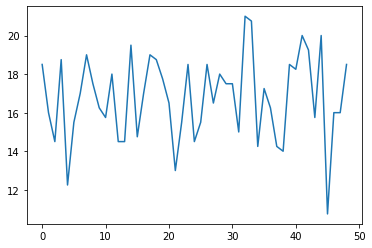

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.04104475e+08 4.37820493e+07 1.32066093e+07 1.53479666e+08] 
UE location : [24 16  6 19 43 18 10 27]
UE ID: 2 Speed: 34.983623027801514 Angle: 1.7891365458385597 Ratio: 0.885602
Reward 27.206609343187807

Battery : 50000000 
UAV loc : [42.22132556408553, 15.305298517745314] 
Task : 292366190.6568122 [1.01104475e+08 4.07820493e+07 0.00000000e+00 1.50479666e+08] 
UE location : [23 15  5 18 43 18  9 27]
UE ID: 1 Speed: 12.148800492286682 Angle: 1.6732597644540679 Ratio: 0.6113358
Reward 13.718745662852644

Battery : 50000000 
UAV loc : [97.86947147798628, 60.961886053715375] 
Task : 278647444.99395955 [9.81044751e+07 3.30633037e+07 0.00000000e+00 1.47479666e+08] 
UE location : [23 15  5 17 43 17  8 26]
UE ID: 2 Speed: 41.59841239452362 Angle: 4.718944725914948 Ratio: 0.98731995
Reward -41.0

Battery : 50000000 
UAV loc : [14.217813070911234, 63.563243989693774] 
Task : 269647444.99395955 [9.51044751e+07 3.00633037e+07 0.00000000e+

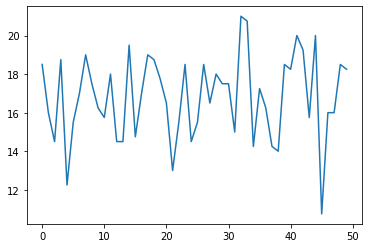

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.04184573e+08 7.86432345e+07 4.39030170e+07 8.78419755e+07] 
UE location : [38 39  9 24 12 23 44 77]
UE ID: 2 Speed: 6.826306879520416 Angle: 0.06276550540666358 Ratio: 0.72533596
Reward 19.922434375310658

Battery : 50000000 
UAV loc : [81.28651456443095, 42.817533867909674] 
Task : 294650365.62468934 [1.01184573e+08 7.56432345e+07 3.29805827e+07 8.48419755e+07] 
UE location : [38 39  9 24 12 23 44 76]
UE ID: 2 Speed: 43.03424954414368 Angle: 1.1807513764056805 Ratio: 0.8893514
Reward 36.112866742980245

Battery : 50000000 
UAV loc : [35.05731720147196, 61.956567638463866] 
Task : 258537498.8817091 [98184572.9320326  72643234.50006656  5867715.92627222 81841975.52333772] 
UE location : [38 39  9 24 12 22 44 75]
UE ID: 0 Speed: 26.52932107448578 Angle: 2.8376204662595037 Ratio: 0.16881895
Reward 12.609321942983627

Battery : 50000000 
UAV loc : [25.576963739086978, 10.287121251496956] 
Task : 245928176.93872547 [94575250.989048

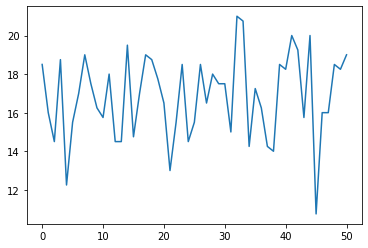

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [5.19794977e+07 2.01566045e+08 3.04073578e+07 3.06199001e+07] 
UE location : [36 74 56  2  0  9 63 65]
UE ID: 0 Speed: 6.523200869560242 Angle: 1.2172708675090709 Ratio: 0.58446145
Reward 16.219546788532853

Battery : 50000000 
UAV loc : [25.838034707805946, 11.979311681068339] 
Task : 298353253.21146715 [4.47599509e+07 1.98566045e+08 2.74073578e+07 2.76199001e+07] 
UE location : [35 74 56  2  0  8 63 64]
UE ID: 1 Speed: 18.035322427749634 Angle: 3.567134129134619 Ratio: 0.95006037
Reward 38.724622068521946

Battery : 50000000 
UAV loc : [58.881358135224104, 53.407761101587425] 
Task : 259628631.1429452 [4.17599509e+07 1.68841422e+08 2.44073578e+07 2.46199001e+07] 
UE location : [34 74 55  2  0  7 62 63]
UE ID: 2 Speed: 26.25177502632141 Angle: 0.5881526144828967 Ratio: 0.0752047
Reward 12.243961123884528

Battery : 50000000 
UAV loc : [72.19705880540346, 2.7097645479898347] 
Task : 247384670.01906067 [3.87599509e+07 1.65841422e+

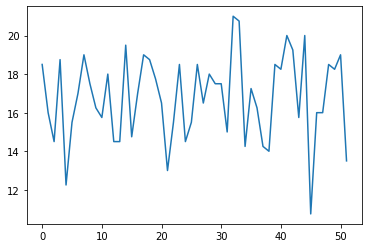

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.00488398e+08 1.79664910e+07 4.83427245e+07 1.47775186e+08] 
UE location : [48 64 79 62 47 74 92  9]
UE ID: 1 Speed: 15.10065346956253 Angle: 5.04523959192012 Ratio: 0.24334133
Reward 12.964799593150675

Battery : 50000000 
UAV loc : [93.39649750515093, 27.18507851215861] 
Task : 301608000.4068493 [9.74883982e+07 1.40016914e+07 4.53427245e+07 1.44775186e+08] 
UE location : [48 64 79 61 46 73 91  9]
UE ID: 1 Speed: 21.14500105381012 Angle: 0.29580737235297283 Ratio: 0.6180964
Reward 16.855385726140558

Battery : 50000000 
UAV loc : [37.68902591466485, 65.08946358424055] 
Task : 284752614.68070877 [9.44883982e+07 6.14630571e+06 4.23427245e+07 1.41775186e+08] 
UE location : [47 64 78 61 45 73 91  9]
UE ID: 0 Speed: 46.009254455566406 Angle: 4.104052871372517 Ratio: 0.07659304
Reward 12.24883841531074

Battery : 50000000 
UAV loc : [60.539472099921454, 66.57339253980581] 
Task : 272503776.265398 [9.12395598e+07 3.14630571e+06 3.934

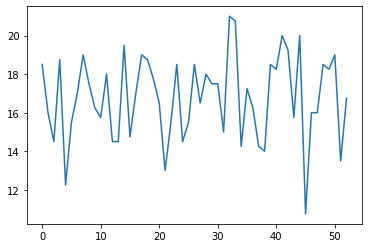

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.42511053e+08 9.30607688e+06 2.18746102e+07 4.08810597e+07] 
UE location : [52 36 20 75 99 75 82 23]
UE ID: 1 Speed: 6.602640450000763 Angle: 1.898154043746362 Ratio: 0.8576187
Reward 23.306076881356596

Battery : 50000000 
UAV loc : [12.302746002421827, 25.200890242246032] 
Task : 296266723.1186434 [2.39511053e+08 0.00000000e+00 1.88746102e+07 3.78810597e+07] 
UE location : [51 36 19 75 98 75 81 22]
UE ID: 2 Speed: 39.164188504219055 Angle: 2.8457485795480477 Ratio: 0.5115635
Reward 12.14204687108165

Battery : 50000000 
UAV loc : [83.99910122759877, 61.91059409577804] 
Task : 284124676.24756175 [2.36511053e+08 0.00000000e+00 1.27325634e+07 3.48810597e+07] 
UE location : [51 35 18 74 97 75 81 22]
UE ID: 3 Speed: 11.41674667596817 Angle: 2.5712195730215637 Ratio: 0.5062934
Reward 12.076483679507316

Battery : 50000000 
UAV loc : [38.96302273769834, 7.502203023608445] 
Task : 272048192.56805444 [2.33511053e+08 0.00000000e+00 9.7

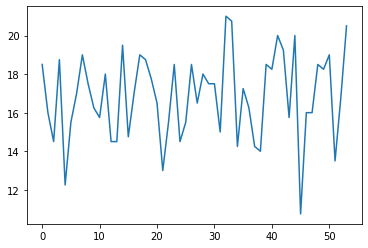

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [6.71344731e+07 7.39317482e+07 6.70601908e+07 1.06446388e+08] 
UE location : [68 29 24 73 16  0 60 79]
UE ID: 1 Speed: 7.258707284927368 Angle: 2.91778818974983 Ratio: 0.14457199
Reward 12.507016328831554

Battery : 50000000 
UAV loc : [92.23238433757501, 38.8996688330451] 
Task : 302065783.67116845 [6.41344731e+07 7.04247319e+07 6.40601908e+07 1.03446388e+08] 
UE location : [67 29 24 73 15  0 60 78]
UE ID: 0 Speed: 49.56852197647095 Angle: 3.9193302757235204 Ratio: 0.8239216
Reward 26.03786696816802

Battery : 50000000 
UAV loc : [91.46735832433706, 11.896041580249062] 
Task : 276027916.7030004 [4.70966061e+07 6.74247319e+07 6.10601908e+07 1.00446388e+08] 
UE location : [67 29 23 73 15  0 60 77]
UE ID: 1 Speed: 38.788193464279175 Angle: 0.4720563719798256 Ratio: 0.5330014
Reward 15.42400244239396

Battery : 50000000 
UAV loc : [1.3484932383050818, 46.624063645464275] 
Task : 260603914.26060647 [44096606.08589171 61000729.4713300

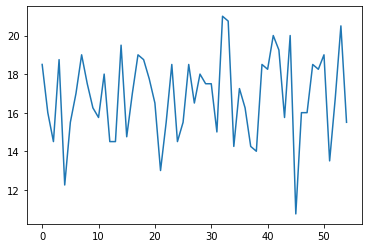

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.54337602e+08 5.49380970e+07 6.08261646e+07 4.44709360e+07] 
UE location : [ 70  59  99   3 100  71  10   2]
UE ID: 2 Speed: 18.608994781970978 Angle: 5.993167813484014 Ratio: 0.58560693
Reward 16.239503351522803

Battery : 50000000 
UAV loc : [16.813781237010517, 67.8404589148272] 
Task : 298333296.6484772 [1.51337602e+08 5.19380970e+07 5.35866613e+07 4.14709360e+07] 
UE location : [70 59 99  3 99 71  9  2]
UE ID: 0 Speed: 26.69461965560913 Angle: 3.980014271066935 Ratio: 0.88376695
Reward 34.81021472595555

Battery : 50000000 
UAV loc : [96.47621421050303, 0.9358109703100581] 
Task : 263523081.92252165 [1.25527388e+08 4.89380970e+07 5.05866613e+07 3.84709360e+07] 
UE location : [69 58 98  2 99 70  9  2]
UE ID: 1 Speed: 32.46430158615112 Angle: 4.882075118847746 Ratio: 0.22587782
Reward 12.875357253814519

Battery : 50000000 
UAV loc : [4.1441671213249265, 93.77675856702012] 
Task : 250647724.66870713 [1.22527388e+08 4.5062739

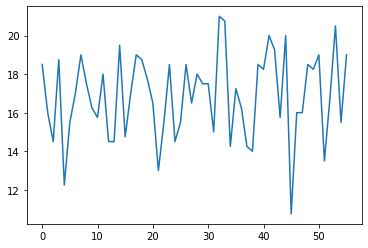

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.35444316e+08 1.20108207e+07 1.27976791e+08 3.91408725e+07] 
UE location : [23 10 15 54 14  9 33 36]
UE ID: 3 Speed: 46.69144153594971 Angle: 0.038146911394834844 Ratio: 0.8231875
Reward 25.9671233560161

Battery : 50000000 
UAV loc : [65.74732695894454, 21.92976659323449] 
Task : 288605676.6439839 [1.32444316e+08 9.01082066e+06 1.24976791e+08 2.21737491e+07] 
UE location : [22  9 15 53 13  9 32 35]
UE ID: 3 Speed: 36.09980344772339 Angle: 5.220436975811527 Ratio: 0.32956952
Reward 13.474736878883839

Battery : 50000000 
UAV loc : [69.11035877170093, 38.95210758034011] 
Task : 275130939.76510006 [1.29444316e+08 6.01082066e+06 1.21976791e+08 1.76990122e+07] 
UE location : [22  9 14 53 12  9 32 35]
UE ID: 0 Speed: 37.871819734573364 Angle: 5.266991195484498 Ratio: 0.47743067
Reward 14.740865060611606

Battery : 50000000 
UAV loc : [94.61447436688104, 75.68955453874366] 
Task : 260390074.70448846 [1.23703450e+08 3.01082066e+06 1.1

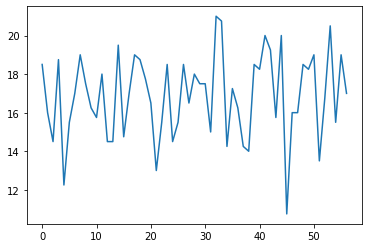

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.45446613e+07 1.78339552e+08 6.28104881e+07 5.88780987e+07] 
UE location : [18 55 53 78 57  8 81 24]
UE ID: 3 Speed: 40.58605432510376 Angle: 1.9620273409427145 Ratio: 0.34566522
Reward 13.584808992890835

Battery : 50000000 
UAV loc : [52.345372025283154, 48.061406511135374] 
Task : 300987991.00710917 [1.15446613e+07 1.75339552e+08 5.98104881e+07 5.42932897e+07] 
UE location : [18 54 53 78 57  7 80 23]
UE ID: 3 Speed: 1.9475147128105164 Angle: 1.5654067961507407 Ratio: 0.1758878
Reward 12.640280990403175

Battery : 50000000 
UAV loc : [35.58681646939874, 0.8892939244930176] 
Task : 288347710.016706 [8.54466127e+06 1.72339552e+08 5.68104881e+07 5.06530088e+07] 
UE location : [18 54 52 77 56  7 79 22]
UE ID: 2 Speed: 47.82997965812683 Angle: 2.0441720870353963 Ratio: 0.590427
Reward 16.32470124769062

Battery : 50000000 
UAV loc : [21.85565332312933, 54.03799983790236] 
Task : 272023008.7690154 [5.54466127e+06 1.69339552e+08 4.9

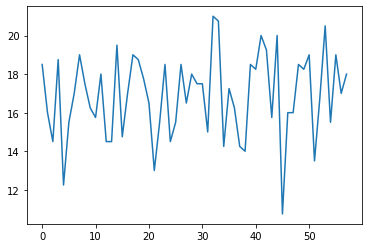

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.13384849e+08 4.15881124e+07 7.74900377e+07 8.21098013e+07] 
UE location : [57 86 94 72 86 55 19 62]
UE ID: 1 Speed: 2.7224868535995483 Angle: 2.7959878306988375 Ratio: 0.418625
Reward 14.160180580927312

Battery : 50000000 
UAV loc : [56.15081971708946, 92.22854351276624] 
Task : 300412619.4190727 [1.10384849e+08 3.64279318e+07 7.44900377e+07 7.91098013e+07] 
UE location : [56 86 93 72 85 55 18 62]
UE ID: 2 Speed: 1.5688955783843994 Angle: 1.154611347591414 Ratio: 0.5755876
Reward 16.068595999218584

Battery : 50000000 
UAV loc : [78.50834722592026, 33.64851200099679] 
Task : 284344023.4198541 [1.07384849e+08 3.34279318e+07 6.74214417e+07 7.61098013e+07] 
UE location : [55 86 92 71 85 54 17 62]
UE ID: 0 Speed: 24.512217938899994 Angle: 2.0246774981846642 Ratio: 0.6434356
Reward 17.41362732311654

Battery : 50000000 
UAV loc : [23.920726656029956, 32.10794527394398] 
Task : 266930396.09673756 [98971221.2483015  30427931.8473375

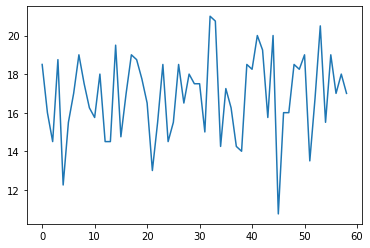

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [6.02529224e+07 1.13608546e+08 5.26035838e+07 8.81077481e+07] 
UE location : [52 36 13 52  2 45 46 55]
UE ID: 2 Speed: 15.941578149795532 Angle: 5.7366892967071665 Ratio: 0.94621015
Reward 38.86866337829447

Battery : 50000000 
UAV loc : [38.03003486975172, 28.47869806259382] 
Task : 275704136.62170553 [5.72529224e+07 1.10608546e+08 2.27349204e+07 8.51077481e+07] 
UE location : [51 35 13 52  2 45 45 55]
UE ID: 1 Speed: 31.852135062217712 Angle: 2.9470596590811633 Ratio: 0.7188254
Reward 19.6695270435991

Battery : 50000000 
UAV loc : [77.86931035981581, 63.59820285015587] 
Task : 256034609.57810643 [54252922.41654269 99939018.65868545 19734920.41150218 82107748.09137613] 
UE location : [51 34 12 51  1 44 45 55]
UE ID: 2 Speed: 46.6653048992157 Angle: 4.5343655664577875 Ratio: 0.54869425
Reward 15.64737823466313

Battery : 50000000 
UAV loc : [39.43952427358681, 32.958667918160245] 
Task : 240387231.3434433 [51252922.41654269 9693

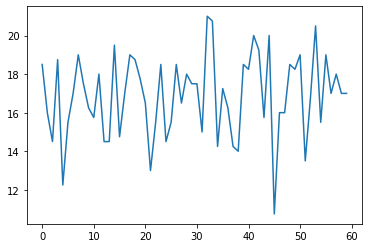

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.02027083e+07 1.74318683e+08 7.50868731e+07 4.49645356e+07] 
UE location : [20 25 24 95 62 40 40 43]
UE ID: 0 Speed: 47.14430868625641 Angle: 1.0989298298784151 Ratio: 0.7482029
Reward 20.914355796038986

Battery : 50000000 
UAV loc : [57.05731091942425, 0.7554195586067181] 
Task : 293658444.203961 [8.28835249e+06 1.71318683e+08 7.20868731e+07 4.19645356e+07] 
UE location : [19 24 23 95 62 39 39 42]
UE ID: 0 Speed: 27.163344621658325 Angle: 2.5786265730271305 Ratio: 0.36184645
Reward 13.701062911668123

Battery : 50000000 
UAV loc : [8.592649398718777, 74.75880424933905] 
Task : 279957381.2922929 [3.58728957e+06 1.68318683e+08 6.90868731e+07 3.89645356e+07] 
UE location : [19 24 22 95 61 38 39 41]
UE ID: 1 Speed: 35.38298010826111 Angle: 1.455665188903735 Ratio: 0.84556496
Reward 28.425643479905336

Battery : 50000000 
UAV loc : [65.733855758387, 9.24605901547011] 
Task : 251531737.81238756 [5.87289575e+05 1.48893040e+08 6.6086

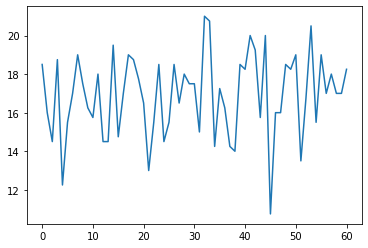

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [3.87732118e+06 3.69041447e+06 1.14229999e+08 1.92775065e+08] 
UE location : [29 87 63 91 66 25 60 34]
UE ID: 1 Speed: 31.323722004890442 Angle: 5.09873305232032 Ratio: 0.13173413
Reward 12.455162886408866

Battery : 50000000 
UAV loc : [19.708118988683054, 98.50612993662367] 
Task : 302117637.11359113 [8.77321183e+05 2.35251582e+05 1.11229999e+08 1.89775065e+08] 
UE location : [29 87 62 90 65 25 60 34]
UE ID: 3 Speed: 7.033558189868927 Angle: 1.8248397988737866 Ratio: 0.32815382
Reward 18.577880574781

Battery : 50000000 
UAV loc : [5.955272034404402, 68.60600234753065] 
Task : 293539756.53881013 [0.00000000e+00 0.00000000e+00 1.08229999e+08 1.85309757e+08] 
UE location : [29 87 62 89 65 24 59 33]
UE ID: 3 Speed: 21.304696798324585 Angle: 6.177415534221136 Ratio: 0.8038338
Reward 18.293153127367198

Battery : 50000000 
UAV loc : [85.90905396272319, 35.68085977726696] 
Task : 275246603.41144294 [0.00000000e+00 0.00000000e+00 1.05

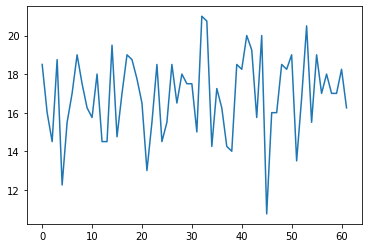

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.33781898e+08 2.40891750e+07 1.59549870e+07 4.07467398e+07] 
UE location : [60  8 50 68 60 76 13 37]
UE ID: 3 Speed: 8.32577794790268 Angle: 0.0021444272440022416 Ratio: 0.39114633
Reward 13.927292316362918

Battery : 50000000 
UAV loc : [32.57588045811417, 1.7854011375163736] 
Task : 300645507.6836371 [2.30781898e+08 2.10891750e+07 1.29549870e+07 3.58194475e+07] 
UE location : [59  7 49 67 59 76 13 37]
UE ID: 3 Speed: 4.273808002471924 Angle: 0.4161993977240718 Ratio: 0.88945985
Reward 36.1394597952286

Battery : 50000000 
UAV loc : [48.484234941031445, 48.67528698131025] 
Task : 264506047.88840848 [2.27781898e+08 1.80891750e+07 9.95498700e+06 8.67998767e+06] 
UE location : [59  6 49 67 59 75 13 37]
UE ID: 2 Speed: 21.339833736419678 Angle: 3.171488800644318 Ratio: 0.7134752
Reward 23.954987001568945

Battery : 50000000 
UAV loc : [84.60629515418248, 3.740320496834215] 
Task : 245551060.88683954 [2.24781898e+08 1.50891750e+07 

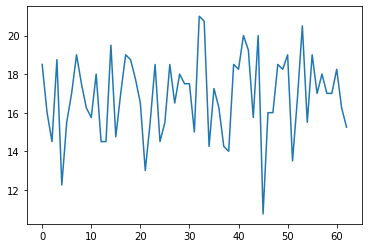

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.96941934e+07 8.95136824e+06 1.40606916e+08 1.35320322e+08] 
UE location : [66 38  0 38 45 27 34 28]
UE ID: 3 Speed: 42.11750030517578 Angle: 3.068631007084355 Ratio: 0.6448349
Reward 17.446775310378968

Battery : 50000000 
UAV loc : [0.5445837908240492, 92.9763540858886] 
Task : 297126024.68962103 [2.66941934e+07 5.95136824e+06 1.37606916e+08 1.26873547e+08] 
UE location : [66 38  0 38 45 26 34 27]
UE ID: 1 Speed: 22.322411835193634 Angle: 4.195144964878132 Ratio: 0.6249718
Reward 19.95136823571473

Battery : 50000000 
UAV loc : [49.354879614134006, 42.59576096945921] 
Task : 282174656.4539063 [2.36941934e+07 0.00000000e+00 1.34606916e+08 1.23873547e+08] 
UE location : [65 38  0 37 44 26 34 27]
UE ID: 2 Speed: 7.7458202838897705 Angle: 0.8423852126110744 Ratio: 0.50006944
Reward 12.000833388674021

Battery : 50000000 
UAV loc : [51.115441499700864, 37.59479948333251] 
Task : 270173823.0652323 [2.06941934e+07 0.00000000e+00 1.2

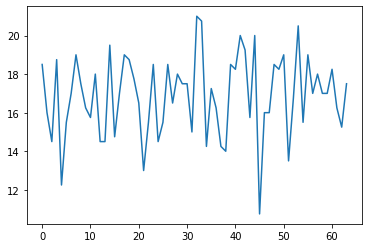

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [3.15297467e+07 1.76323862e+08 6.73844677e+07 3.93347233e+07] 
UE location : [24 81 15 57 38 63 71 66]
UE ID: 0 Speed: 17.384538054466248 Angle: 0.6016891710205252 Ratio: 0.3234204
Reward 13.434068103576005

Battery : 50000000 
UAV loc : [33.147695854296444, 15.972909143567904] 
Task : 301138731.896424 [2.70956786e+07 1.73323862e+08 6.43844677e+07 3.63347233e+07] 
UE location : [24 80 14 57 38 62 71 66]
UE ID: 3 Speed: 28.373005986213684 Angle: 4.7371716084749105 Ratio: 0.4730424
Reward 14.693057643629789

Battery : 50000000 
UAV loc : [14.92184657391249, 39.138424125567894] 
Task : 286445674.2527942 [2.40956786e+07 1.70323862e+08 6.13844677e+07 3.06416657e+07] 
UE location : [23 80 13 56 37 62 71 65]
UE ID: 2 Speed: 18.443238735198975 Angle: 1.312262889953809 Ratio: 0.14255372
Reward 12.498761449109912

Battery : 50000000 
UAV loc : [36.28996076350859, 96.8719593425817] 
Task : 273946912.8036843 [2.10956786e+07 1.67323862e+08 5.

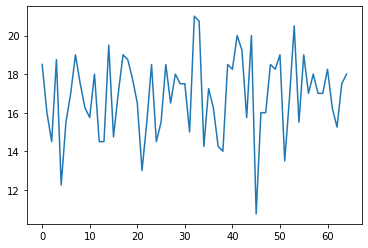

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.70074214e+07 3.43487810e+05 2.01188859e+08 9.60330316e+07] 
UE location : [50 24 93 15 11 32 31 26]
UE ID: 0 Speed: 42.47191846370697 Angle: 4.441756719487588 Ratio: 0.22511414
Reward 15.215025726409078

Battery : 50000000 
UAV loc : [64.55259742180885, 92.60281188587669] 
Task : 304357774.2735909 [1.31358835e+07 0.00000000e+00 1.98188859e+08 9.30330316e+07] 
UE location : [50 23 92 14 10 31 30 25]
UE ID: 3 Speed: 48.25236201286316 Angle: 2.1620395605287763 Ratio: 0.5373246
Reward 12.484027566198945

Battery : 50000000 
UAV loc : [34.296257664598784, 66.42558462473289] 
Task : 291873746.707392 [1.01358835e+07 0.00000000e+00 1.95188859e+08 8.65490040e+07] 
UE location : [50 23 91 13 10 30 30 25]
UE ID: 1 Speed: 25.202685594558716 Angle: 0.6607483676216931 Ratio: 0.83712107
Reward -41.0

Battery : 50000000 
UAV loc : [19.461400331465484, 10.732850683376682] 
Task : 282873746.707392 [7.13588353e+06 0.00000000e+00 1.92188859e+08 8

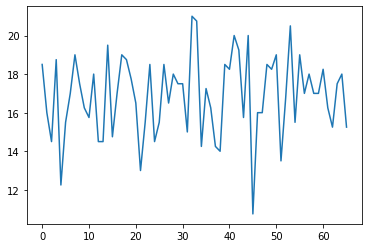

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.91389768e+08 6.62582452e+06 3.02870538e+07 8.62701537e+07] 
UE location : [11 89 89 89  0 86 57 54]
UE ID: 0 Speed: 28.705620765686035 Angle: 1.8809922591748631 Ratio: 0.973667
Reward 37.963762087221504

Battery : 50000000 
UAV loc : [76.22536283258512, 66.43899849248669] 
Task : 276609037.9127785 [1.62426006e+08 3.62582452e+06 2.72870538e+07 8.32701537e+07] 
UE location : [10 89 88 89  0 86 57 53]
UE ID: 1 Speed: 47.109052538871765 Angle: 3.3100597716757583 Ratio: 0.6425543
Reward 17.62582452057773

Battery : 50000000 
UAV loc : [21.676427939985388, 54.015931040362375] 
Task : 263983213.39220077 [1.59426006e+08 0.00000000e+00 2.42870538e+07 8.02701537e+07] 
UE location : [10 89 87 89  0 85 57 53]
UE ID: 1 Speed: 9.216925501823425 Angle: 2.606846801130047 Ratio: 0.61051255
Reward -41.0

Battery : 50000000 
UAV loc : [25.379795321433107, 71.30826228629417] 
Task : 254983213.39220077 [1.56426006e+08 0.00000000e+00 2.12870538e+07

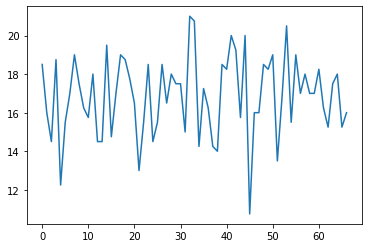

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.31512964e+08 3.89565997e+07 2.70482254e+07 1.70550110e+07] 
UE location : [52 58 13 36 86 59 58  6]
UE ID: 2 Speed: 21.359366178512573 Angle: 4.04479275175067 Ratio: 0.8861434
Reward 35.34893050297952

Battery : 50000000 
UAV loc : [77.64149739863058, 77.37688850053246] 
Task : 279223869.4970205 [2.28512964e+08 3.59565997e+07 6.99294930e+05 1.40550110e+07] 
UE location : [52 58 13 35 86 58 57  6]
UE ID: 1 Speed: 33.23926329612732 Angle: 1.5417658527362692 Ratio: 0.9471817
Reward 41.50904942678666

Battery : 50000000 
UAV loc : [60.631343673549054, 60.21462795458774] 
Task : 242714820.07023382 [2.25512964e+08 6.14684522e+06 0.00000000e+00 1.10550110e+07] 
UE location : [51 58 13 34 85 57 56  5]
UE ID: 2 Speed: 18.381142616271973 Angle: 2.0416385469889984 Ratio: 0.6464586
Reward -41.0

Battery : 50000000 
UAV loc : [29.29768856486419, 59.56548818035117] 
Task : 233714820.07023382 [2.22512964e+08 3.14684522e+06 0.00000000e+00 8.0

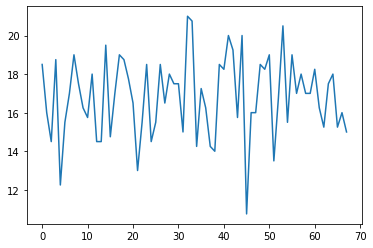

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [3.69750140e+07 1.87159954e+08 5.47337225e+07 3.57041096e+07] 
UE location : [31 68 10 47 26 83 93 69]
UE ID: 2 Speed: 7.095097005367279 Angle: 1.02013149133704 Ratio: 0.47765335
Reward 14.743312463681102

Battery : 50000000 
UAV loc : [28.746280755154885, 4.62772935301814] 
Task : 299829487.5363189 [3.39750140e+07 1.84159954e+08 4.89904101e+07 3.27041096e+07] 
UE location : [31 68  9 46 25 82 93 69]
UE ID: 0 Speed: 29.14080023765564 Angle: 5.395721994347555 Ratio: 0.5396233
Reward 15.516403047759056

Battery : 50000000 
UAV loc : [85.47661911417208, 2.983641985798613] 
Task : 284313084.48855984 [2.74586110e+07 1.81159954e+08 4.59904101e+07 2.97041096e+07] 
UE location : [30 68  8 46 25 81 92 68]
UE ID: 3 Speed: 49.41640794277191 Angle: 3.5976013994072895 Ratio: 0.7970017
Reward 23.77845030134368

Battery : 50000000 
UAV loc : [89.02851339565245, 77.77729820714114] 
Task : 260534634.18721616 [2.44586110e+07 1.78159954e+08 4.29904

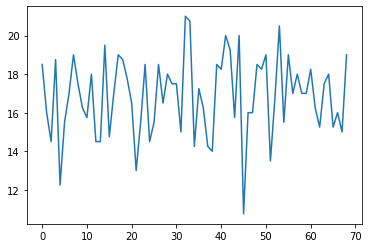

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.59559571e+08 1.36883775e+06 3.21993023e+06 5.04244606e+07] 
UE location : [48  1 38 36 88 34 32 93]
UE ID: 1 Speed: 40.441566705703735 Angle: 5.36276200529457 Ratio: 0.9550499
Reward 15.368837748315036

Battery : 50000000 
UAV loc : [48.66941846182158, 18.574413495622366] 
Task : 304203962.25168496 [2.56559571e+08 0.00000000e+00 2.19930226e+05 4.74244606e+07] 
UE location : [47  1 37 36 88 34 32 92]
UE ID: 2 Speed: 38.84902000427246 Angle: 4.513981523414861 Ratio: 0.10013205
Reward 11.21993022639197

Battery : 50000000 
UAV loc : [98.80451023929311, 48.754427465476624] 
Task : 297984032.025293 [2.53559571e+08 0.00000000e+00 0.00000000e+00 4.44244606e+07] 
UE location : [47  0 36 35 88 34 32 91]
UE ID: 1 Speed: 44.7827935218811 Angle: 3.7816775959254536 Ratio: 0.927011
Reward -44.0

Battery : 50000000 
UAV loc : [88.66933633991039, 0.7296282989415204] 
Task : 291984032.025293 [2.50559571e+08 0.00000000e+00 0.00000000e+00 4.1424

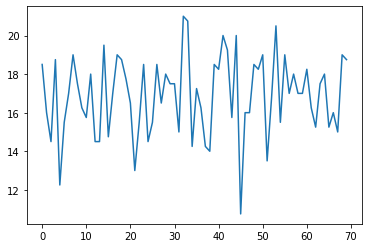

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.20354160e+08 1.31258956e+07 3.58816051e+07 4.52111390e+07] 
UE location : [71 48 14 58 86  1 65 20]
UE ID: 3 Speed: 40.85071682929993 Angle: 5.577884085444117 Ratio: 0.27204078
Reward 13.121109995644867

Battery : 50000000 
UAV loc : [89.55977129182884, 48.201698947860905] 
Task : 301451690.00435513 [2.17354160e+08 1.01258956e+07 3.28816051e+07 4.10900290e+07] 
UE location : [70 47 13 57 85  1 65 19]
UE ID: 2 Speed: 6.540961563587189 Angle: 0.6103749252741966 Ratio: 0.2551149
Reward 13.027466856705427

Battery : 50000000 
UAV loc : [91.96522114355048, 4.918719631115209] 
Task : 288424223.1476497 [2.14354160e+08 7.12589563e+06 2.88541383e+07 3.80900290e+07] 
UE location : [69 46 13 56 85  0 65 19]
UE ID: 1 Speed: 0.41300803422927856 Angle: 0.7247508697428064 Ratio: 0.40806222
Reward 14.068100228495062

Battery : 50000000 
UAV loc : [27.4425640705374, 80.74771269808139] 
Task : 274356122.91915464 [2.11354160e+08 2.05779540e+06 2

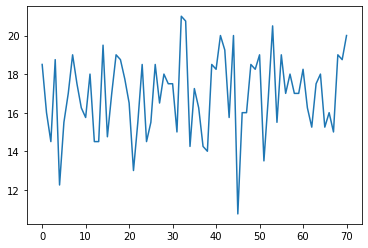

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.44100934e+07 1.29090721e+08 1.56510985e+08 4.56100071e+06] 
UE location : [87 55 99 92 63 39 87 65]
UE ID: 3 Speed: 42.695409059524536 Angle: 0.4479778171027945 Ratio: 0.15507409
Reward 12.550607175921023

Battery : 50000000 
UAV loc : [48.243276292060955, 49.325075284019704] 
Task : 302022192.824079 [2.14100934e+07 1.26090721e+08 1.53510985e+08 1.01039354e+06] 
UE location : [87 54 98 92 63 38 86 65]
UE ID: 1 Speed: 18.154817819595337 Angle: 3.0262875571839896 Ratio: 0.94167536
Reward 41.91756481973237

Battery : 50000000 
UAV loc : [20.901137769516254, 58.6217206257686] 
Task : 265104628.0043466 [1.84100934e+07 9.61835497e+07 1.50510985e+08 0.00000000e+00] 
UE location : [86 53 97 91 63 38 85 65]
UE ID: 0 Speed: 23.74792844057083 Angle: 1.924645547406681 Ratio: 0.98516023
Reward 29.410093388804377

Battery : 50000000 
UAV loc : [67.22167000719139, 89.8366765870719] 
Task : 240694534.61554223 [0.00000000e+00 9.31835497e+07 1.

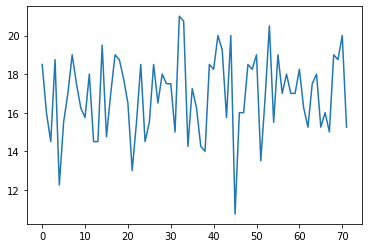

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [4.93353329e+07 5.07767615e+06 3.05503108e+07 2.29609480e+08] 
UE location : [16 84 96 71 75 58 95 41]
UE ID: 3 Speed: 9.983418881893158 Angle: 5.495422506405499 Ratio: 0.59469426
Reward 16.401819614459157

Battery : 50000000 
UAV loc : [95.73693165792747, 92.39837741648671] 
Task : 298170980.38554084 [4.63353329e+07 2.07767615e+06 2.75503108e+07 2.22207660e+08] 
UE location : [15 83 95 70 75 57 94 41]
UE ID: 2 Speed: 46.44649624824524 Angle: 5.786148192891573 Ratio: 0.8213807
Reward 29.87317124763608

Battery : 50000000 
UAV loc : [56.33642793347917, 25.160760353315936] 
Task : 273297809.13790476 [4.33353329e+07 0.00000000e+00 1.07548157e+07 2.19207660e+08] 
UE location : [15 83 94 69 75 57 93 41]
UE ID: 3 Speed: 17.039263248443604 Angle: 5.088383925100488 Ratio: 0.1868166
Reward 9.689204687240153

Battery : 50000000 
UAV loc : [59.32138975732073, 68.81866605798734] 
Task : 263608604.4506646 [4.03353329e+07 0.00000000e+00 7.7548

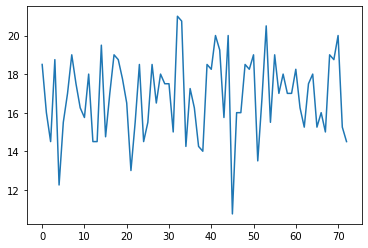

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.13872818e+08 4.63094272e+07 4.88864076e+07 5.50414725e+06] 
UE location : [ 37  93 100  96  85   7   1  86]
UE ID: 1 Speed: 14.092953503131866 Angle: 0.9684038315752382 Ratio: 0.6601621
Reward 17.827737938596844

Battery : 50000000 
UAV loc : [1.4714569285104062, 38.765505888454754] 
Task : 296745062.06140316 [2.10872818e+08 3.74816892e+07 4.58864076e+07 2.50414725e+06] 
UE location : [37 93 99 95 85  6  0 86]
UE ID: 3 Speed: 35.583287477493286 Angle: 2.4750119007629885 Ratio: 0.9342563
Reward 16.504147251492917

Battery : 50000000 
UAV loc : [49.48857097922996, 76.67337438037407] 
Task : 285240914.80991024 [2.07872818e+08 3.44816892e+07 4.28864076e+07 0.00000000e+00] 
UE location : [37 93 99 95 85  6  0 86]
UE ID: 3 Speed: 33.427226543426514 Angle: 5.689059118341912 Ratio: 0.27333063
Reward -41.0

Battery : 50000000 
UAV loc : [81.23601619397505, 3.8682127111542286] 
Task : 276240914.80991024 [2.04872818e+08 3.14816892e+07 3.

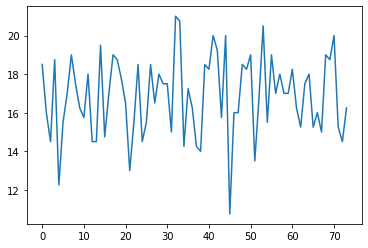

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [7.71430228e+07 4.29296344e+07 7.40512000e+07 1.20448943e+08] 
UE location : [55 98 85 18 42 62 31  4]
UE ID: 3 Speed: 14.630430936813354 Angle: 0.1506218581878326 Ratio: 0.43591166
Reward 14.318315878811001

Battery : 50000000 
UAV loc : [46.478457497516956, 19.533974510207486] 
Task : 300254484.121189 [7.41430228e+07 3.99296344e+07 7.10512000e+07 1.15130627e+08] 
UE location : [55 97 84 17 42 62 31  3]
UE ID: 0 Speed: 8.436228334903717 Angle: 2.3052450560353344 Ratio: 0.1311205
Reward 12.452722742545188

Battery : 50000000 
UAV loc : [82.46819857687058, 20.4654155860311] 
Task : 287801761.3786438 [7.06903001e+07 3.69296344e+07 6.80512000e+07 1.12130627e+08] 
UE location : [54 97 84 16 41 62 30  3]
UE ID: 2 Speed: 45.52338123321533 Angle: 4.163825316609068 Ratio: 0.4779305
Reward 14.746361204232574

Battery : 50000000 
UAV loc : [72.9477034024967, 37.85200850089723] 
Task : 273055400.17441124 [6.76903001e+07 3.39296344e+07 6.230

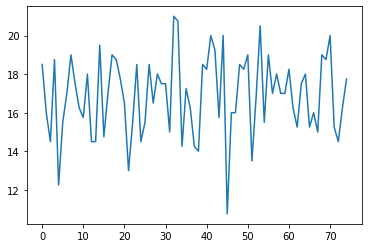

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.07903814e+07 3.00975644e+07 1.32744863e+07 2.50410368e+08] 
UE location : [71 95 84 71  7 82 31 98]
UE ID: 3 Speed: 18.858666718006134 Angle: 3.6981318190399297 Ratio: 0.9319476
Reward 39.17581296208811

Battery : 50000000 
UAV loc : [1.2674790438637729, 3.78939758461172] 
Task : 275396987.0379119 [1.77903814e+07 2.70975644e+07 1.02744863e+07 2.20234555e+08] 
UE location : [70 94 83 70  7 81 31 97]
UE ID: 1 Speed: 17.526713013648987 Angle: 4.3129764856967965 Ratio: 0.12669569
Reward 12.435228676156193

Battery : 50000000 
UAV loc : [45.17408924629365, 35.778119418279175] 
Task : 262961758.3617557 [1.47903814e+07 2.36623357e+07 7.27448633e+06 2.17234555e+08] 
UE location : [69 94 82 70  6 81 30 97]
UE ID: 0 Speed: 8.821430802345276 Angle: 4.663226319259662 Ratio: 0.9279674
Reward 28.79038136830428

Battery : 50000000 
UAV loc : [74.05789124212276, 96.73470235914294] 
Task : 239171376.99345142 [0.00000000e+00 2.06623357e+07 4.27

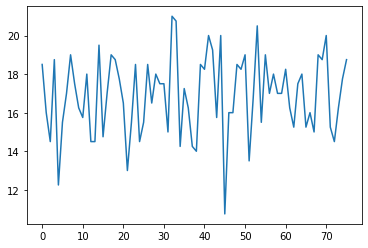

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [5.03480098e+07 1.92219337e+08 3.94611792e+07 3.25442742e+07] 
UE location : [ 91  79  74  41   9 100  79  25]
UE ID: 0 Speed: 2.713005244731903 Angle: 0.30832246097093385 Ratio: 0.9437537
Reward 38.95775265681535

Battery : 50000000 
UAV loc : [58.50707081411883, 82.32902840755969] 
Task : 275615047.34318465 [2.03902571e+07 1.89219337e+08 3.64611792e+07 2.95442742e+07] 
UE location : [90 79 73 41  9 99 78 25]
UE ID: 0 Speed: 17.703095078468323 Angle: 2.733956359067627 Ratio: 0.5112038
Reward 15.137527575595051

Battery : 50000000 
UAV loc : [25.45592920385502, 65.27492689500605] 
Task : 260477519.7675896 [1.42527295e+07 1.86219337e+08 3.34611792e+07 2.65442742e+07] 
UE location : [90 78 72 41  8 98 77 24]
UE ID: 2 Speed: 16.98106825351715 Angle: 1.1922816987927467 Ratio: 0.35230386
Reward 13.631801591270387

Battery : 50000000 
UAV loc : [26.887582510482844, 94.6017141279242] 
Task : 246845718.1763192 [1.12527295e+07 1.83219337e

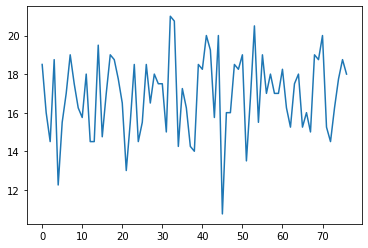

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.98626284e+07 6.32251974e+07 2.06004101e+08 2.54808730e+07] 
UE location : [32 55 98 49 11 84  3  0]
UE ID: 1 Speed: 24.253655970096588 Angle: 2.9334652412076636 Ratio: 0.84166306
Reward 27.946937137604117

Battery : 50000000 
UAV loc : [26.974861796674077, 98.85134679108774] 
Task : 286625862.8623959 [1.68626284e+07 4.42782603e+07 2.03004101e+08 2.24808730e+07] 
UE location : [31 55 98 49 10 84  3  0]
UE ID: 1 Speed: 23.88671636581421 Angle: 4.4755462416082405 Ratio: 0.6877568
Reward 18.607894670532374

Battery : 50000000 
UAV loc : [62.97902314934731, 36.85389619475927] 
Task : 268017968.1918635 [1.38626284e+07 3.46703656e+07 2.00004101e+08 1.94808730e+07] 
UE location : [30 54 97 48  9 84  3  0]
UE ID: 3 Speed: 10.255764424800873 Angle: 3.8043648571923785 Ratio: 0.5701162
Reward 15.978630394690812

Battery : 50000000 
UAV loc : [89.45116019831971, 54.34780645917385] 
Task : 252039337.7971727 [1.08626284e+07 3.16703656e+07 1.

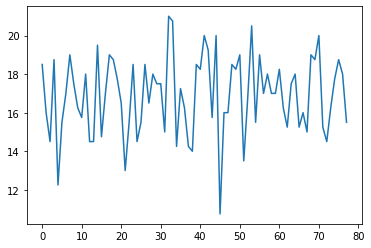

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [5.95528269e+07 1.10525023e+08 3.73452839e+07 1.07149666e+08] 
UE location : [ 5 74 88 92 28 17 83 40]
UE ID: 3 Speed: 43.695276975631714 Angle: 0.3821735616685664 Ratio: 0.16338527
Reward 12.58587997520101

Battery : 50000000 
UAV loc : [54.293470211592876, 29.563363963291067] 
Task : 301986920.024799 [5.65528269e+07 1.07525023e+08 3.43452839e+07 1.03563786e+08] 
UE location : [ 4 73 88 92 27 16 83 40]
UE ID: 2 Speed: 1.6170457005500793 Angle: 5.086390424188888 Ratio: 0.064300954
Reward 12.206159089208008

Battery : 50000000 
UAV loc : [88.4246834049975, 5.809993992983209] 
Task : 289780760.935591 [5.35528269e+07 1.04525023e+08 3.11391248e+07 1.00563786e+08] 
UE location : [ 3 73 87 92 26 16 83 40]
UE ID: 3 Speed: 7.131543755531311 Angle: 1.7549800068301802 Ratio: 0.3353408
Reward 13.513591311948538

Battery : 50000000 
UAV loc : [88.14166282306246, 82.0915404627982] 
Task : 276267169.62364244 [5.05528269e+07 1.01525023e+08 2.81

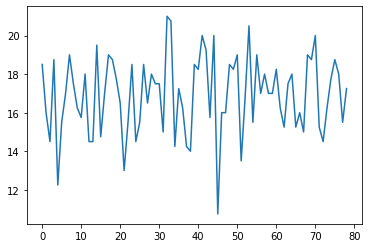

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [4.35339313e+07 1.05650830e+08 1.13801948e+08 5.15860914e+07] 
UE location : [27 65 18 74 16 24 49 46]
UE ID: 0 Speed: 22.27013111114502 Angle: 5.951633486018275 Ratio: 0.66122764
Reward 17.8555041234895

Battery : 50000000 
UAV loc : [94.27370239591824, 75.08334502889511] 
Task : 296717295.8765105 [3.46784272e+07 1.02650830e+08 1.10801948e+08 4.85860914e+07] 
UE location : [27 65 18 73 15 23 49 46]
UE ID: 1 Speed: 31.560730934143066 Angle: 4.7169961658467425 Ratio: 0.72637093
Reward 19.963747409455657

Battery : 50000000 
UAV loc : [41.910802224805366, 47.705094931160374] 
Task : 276753548.46705484 [3.16784272e+07 9.16870823e+07 1.07801948e+08 4.55860914e+07] 
UE location : [26 64 17 73 15 22 48 46]
UE ID: 2 Speed: 19.047513604164124 Angle: 1.7843372382709926 Ratio: 0.5599643
Reward 15.817628648219406

Battery : 50000000 
UAV loc : [12.57793658157027, 31.997563351990266] 
Task : 260935919.81883544 [2.86784272e+07 8.86870823e+07 

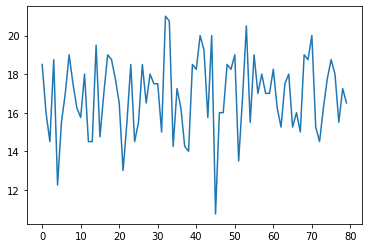

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [4.19939359e+06 2.56501722e+08 1.10730065e+07 4.27986781e+07] 
UE location : [55 86  9 88  0 10 34 63]
UE ID: 2 Speed: 28.62774133682251 Angle: 5.2940118775757945 Ratio: 0.10521558
Reward 12.352762889587282

Battery : 50000000 
UAV loc : [27.247121340656122, 7.945627050062853] 
Task : 302220037.1104127 [1.19939359e+06 2.53501722e+08 7.72024358e+06 3.97986781e+07] 
UE location : [55 86  9 88  0  9 34 62]
UE ID: 0 Speed: 22.02381193637848 Angle: 2.6521610280323418 Ratio: 0.13632408
Reward 15.199393593423485

Battery : 50000000 
UAV loc : [19.10996510269456, 29.955658852597367] 
Task : 292020643.51698923 [0.00000000e+00 2.50501722e+08 4.72024358e+06 3.67986781e+07] 
UE location : [55 85  8 87  0  9 34 61]
UE ID: 3 Speed: 0.5113601684570312 Angle: 4.734729073636387 Ratio: 0.5095439
Reward 12.116755350436211

Battery : 50000000 
UAV loc : [87.86120136672366, 55.557371640992415] 
Task : 279903888.166553 [0.00000000e+00 2.47501722e+08 1

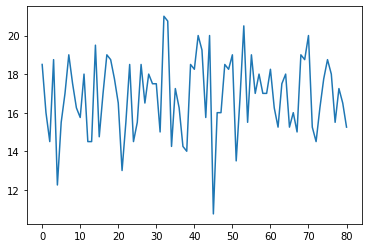

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.29788602e+08 1.68378967e+08 1.62718996e+07 1.33331244e+05] 
UE location : [97 55 45 51 38 79 49 80]
UE ID: 1 Speed: 10.964301228523254 Angle: 5.241836307408155 Ratio: 0.16353044
Reward 14.719833539426864

Battery : 50000000 
UAV loc : [46.240934092764974, 53.68614549742858] 
Task : 304852966.46057314 [1.26788602e+08 1.64792465e+08 1.32718996e+07 0.00000000e+00] 
UE location : [97 55 44 50 37 78 49 79]
UE ID: 2 Speed: 24.882660806179047 Angle: 4.465281003962747 Ratio: 0.9389105
Reward 24.271899617646397

Battery : 50000000 
UAV loc : [15.461508038316651, 44.0676292332256] 
Task : 285581066.84292674 [1.23788602e+08 1.61792465e+08 0.00000000e+00 0.00000000e+00] 
UE location : [96 54 44 50 36 77 49 79]
UE ID: 1 Speed: 24.856948852539062 Angle: 4.590352869159387 Ratio: 0.79586285
Reward 17.696002426965507

Battery : 50000000 
UAV loc : [43.55864808713363, 60.44542820742436] 
Task : 267885064.41596124 [1.20788602e+08 1.47096463e+08 

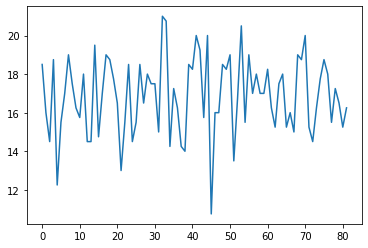

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [6.22359098e+07 3.04854576e+07 1.70874245e+08 5.09771872e+07] 
UE location : [19 88  2 74 23 39 37 53]
UE ID: 3 Speed: 41.27901792526245 Angle: 0.7772498267293766 Ratio: 0.8137917
Reward 25.11098901204431

Battery : 50000000 
UAV loc : [57.44589890091447, 94.98679977065194] 
Task : 289461810.9879557 [5.92359098e+07 2.74854576e+07 1.67874245e+08 3.48661982e+07] 
UE location : [19 87  1 73 23 39 36 52]
UE ID: 2 Speed: 2.243296802043915 Angle: 0.8270776123366511 Ratio: 0.20414788
Reward 12.769544500700713

Battery : 50000000 
UAV loc : [96.46767814248847, 63.77674540827343] 
Task : 276692266.487255 [5.62359098e+07 2.44854576e+07 1.64104701e+08 3.18661982e+07] 
UE location : [18 86  1 72 23 39 35 52]
UE ID: 3 Speed: 14.572076499462128 Angle: 3.7119436382433535 Ratio: 0.2867924
Reward 13.206348880017936

Battery : 50000000 
UAV loc : [20.21934717647582, 9.111956886098938] 
Task : 263485917.60723704 [5.32359098e+07 2.14854576e+07 1.611

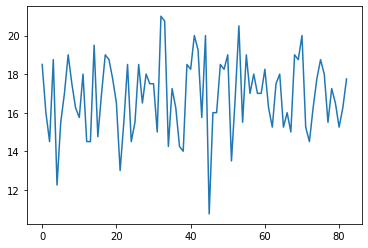

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.13637576e+08 8.13840633e+07 9.13331710e+07 2.82179900e+07] 
UE location : [31 83 67 80 74 27 44 31]
UE ID: 3 Speed: 47.96797037124634 Angle: 1.5415448935895768 Ratio: 0.44134083
Reward 14.370000497719646

Battery : 50000000 
UAV loc : [59.70682075744662, 5.254997476333756] 
Task : 300202799.50228035 [1.10637576e+08 7.83840633e+07 8.83331710e+07 2.28479895e+07] 
UE location : [30 82 66 80 73 26 44 31]
UE ID: 0 Speed: 22.722861170768738 Angle: 1.531946465707957 Ratio: 0.3093642
Reward 13.34382347168964

Battery : 50000000 
UAV loc : [58.93787091550848, 3.928713639191983] 
Task : 286858976.0305907 [1.06293752e+08 7.53840633e+07 8.53331710e+07 1.98479895e+07] 
UE location : [29 81 66 79 73 26 43 31]
UE ID: 2 Speed: 3.0583664774894714 Angle: 4.344644800009201 Ratio: 0.54177034
Reward 15.546935424329758

Battery : 50000000 
UAV loc : [16.164654972556036, 92.51726329423207] 
Task : 271312040.60626096 [1.03293752e+08 7.23840633e+07 7.

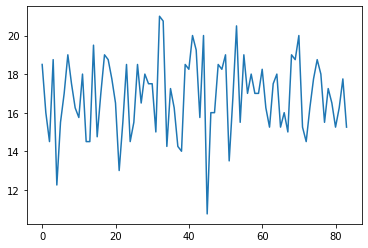

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [3.84581911e+05 1.08803825e+08 1.54439205e+08 5.09451875e+07] 
UE location : [58 29 25 10  5 81 87 20]
UE ID: 3 Speed: 8.844515681266785 Angle: 5.173359944327061 Ratio: 0.15228438
Reward 14.92350456705761

Battery : 50000000 
UAV loc : [6.580082313880098, 7.866586533816644] 
Task : 304649295.4329424 [0.00000000e+00 1.05803825e+08 1.51439205e+08 4.74062649e+07] 
UE location : [58 28 25  9  5 80 87 19]
UE ID: 2 Speed: 21.458208560943604 Angle: 2.8850431677310846 Ratio: 0.84054476
Reward 24.81405718792689

Battery : 50000000 
UAV loc : [17.582662284127082, 68.85113683046598] 
Task : 279835238.2450155 [0.00000000e+00 1.02803825e+08 1.32625148e+08 4.44062649e+07] 
UE location : [58 28 25  9  5 80 87 18]
UE ID: 0 Speed: 23.76796454191208 Angle: 3.826779102835678 Ratio: 0.63525486
Reward -41.0

Battery : 50000000 
UAV loc : [82.0898145306046, 18.964446525777134] 
Task : 270835238.2450155 [0.00000000e+00 9.98038254e+07 1.29625148e+08 4.1

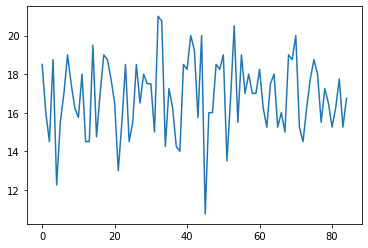

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [3.97492701e+07 1.31525998e+08 6.07705070e+06 1.37220482e+08] 
UE location : [ 9 17 27 65 14 95 52 40]
UE ID: 1 Speed: 7.311464846134186 Angle: 4.468544458207286 Ratio: 0.2677533
Reward 13.096979901035905

Battery : 50000000 
UAV loc : [23.475508873357853, 90.48306151647125] 
Task : 301475820.0989641 [3.67492701e+07 1.27429018e+08 3.07705070e+06 1.34220482e+08] 
UE location : [ 9 17 27 64 13 94 52 39]
UE ID: 3 Speed: 29.03568148612976 Angle: 3.9802696848602306 Ratio: 0.15112925
Reward 12.534106912045836

Battery : 50000000 
UAV loc : [6.668362828028762, 88.74994267728766] 
Task : 288941713.18691826 [3.37492701e+07 1.24429018e+08 7.70506985e+04 1.30686375e+08] 
UE location : [ 8 16 26 63 13 93 52 39]
UE ID: 0 Speed: 3.1328126788139343 Angle: 1.8355003286876437 Ratio: 0.7063873
Reward 21.294591731736062

Battery : 50000000 
UAV loc : [15.125487532927195, 22.636056197734433] 
Task : 272647121.4551822 [2.35317290e+07 1.21429018e+08 0

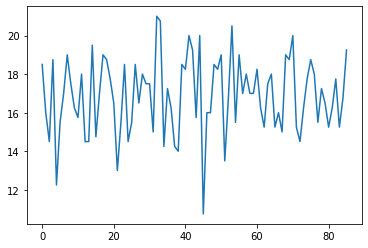

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [4.42229615e+07 1.22079804e+07 1.86780130e+08 7.13617284e+07] 
UE location : [88 57 72 66 33 59 55  8]
UE ID: 3 Speed: 32.493433356285095 Angle: 4.484299968887547 Ratio: 0.24596709
Reward 12.978606186454892

Battery : 50000000 
UAV loc : [65.27004250974926, 34.8137491831892] 
Task : 301594193.8135451 [4.12229615e+07 9.20798039e+06 1.83780130e+08 6.73831222e+07] 
UE location : [88 56 72 65 32 59 54  7]
UE ID: 2 Speed: 31.362760066986084 Angle: 4.909689394578886 Ratio: 0.93216306
Reward 39.277855256534934

Battery : 50000000 
UAV loc : [58.21403090003514, 5.944764787125223] 
Task : 262316338.55701017 [3.82229615e+07 6.20798039e+06 1.53502275e+08 6.43831222e+07] 
UE location : [88 56 71 64 32 59 53  6]
UE ID: 1 Speed: 14.934059977531433 Angle: 2.71831619655208 Ratio: 0.74793744
Reward 20.20798039476246

Battery : 50000000 
UAV loc : [59.79311054803418, 7.892926138174516] 
Task : 247108358.16224772 [3.52229615e+07 0.00000000e+00 1.50

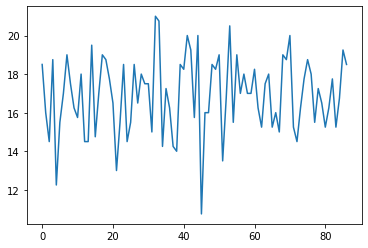

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [3.53102439e+07 9.17043385e+07 7.26217970e+07 1.14936421e+08] 
UE location : [ 3 77 20  6 61 70  6 73]
UE ID: 3 Speed: 9.362922608852386 Angle: 2.9398552673779026 Ratio: 0.8508738
Reward 29.117193101943194

Battery : 50000000 
UAV loc : [82.69580843979725, 12.393449102447107] 
Task : 285455606.8980568 [32310243.93914712 88704338.46619283 69621796.97244655 94819227.5202703 ] 
UE location : [ 3 76 20  5 61 69  5 73]
UE ID: 2 Speed: 4.818610846996307 Angle: 2.710703030427438 Ratio: 0.41953564
Reward 14.168275936851561

Battery : 50000000 
UAV loc : [31.764497184474294, 40.608298437319945] 
Task : 271287330.96120524 [29310243.93914712 85704338.46619283 64453521.03559499 91819227.5202703 ] 
UE location : [ 2 75 19  5 61 68  4 73]
UE ID: 0 Speed: 19.96385306119919 Angle: 5.514585656536193 Ratio: 0.19005033
Reward 12.703933867701352

Battery : 50000000 
UAV loc : [11.620765812591571, 73.08406179053577] 
Task : 258583397.0935039 [2560631

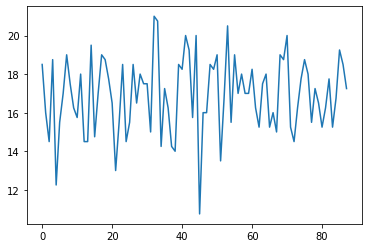

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [8.09689145e+07 7.04313957e+07 1.31496832e+08 3.16756583e+07] 
UE location : [ 43  91  28  98  56  72  80 100]
UE ID: 0 Speed: 10.726119577884674 Angle: 6.187991238193084 Ratio: 0.30688256
Reward 13.328270835452736

Battery : 50000000 
UAV loc : [67.75566979512746, 98.04784646134692] 
Task : 301244529.16454726 [7.66406437e+07 6.74313957e+07 1.28496832e+08 2.86756583e+07] 
UE location : [ 43  91  27  98  55  72  79 100]
UE ID: 2 Speed: 2.3837998509407043 Angle: 0.7919430482238862 Ratio: 0.108546555
Reward 12.365290713686406

Battery : 50000000 
UAV loc : [56.97972528552668, 25.555661482195546] 
Task : 288879238.45086086 [7.36406437e+07 6.44313957e+07 1.25131541e+08 2.56756583e+07] 
UE location : [43 90 26 97 55 72 79 99]
UE ID: 3 Speed: 42.26255416870117 Angle: 2.972531380103442 Ratio: 0.7786541
Reward 22.553447250730304

Battery : 50000000 
UAV loc : [68.02979282117008, 66.66354445426919] 
Task : 266325791.20013055 [7.06406437e+0

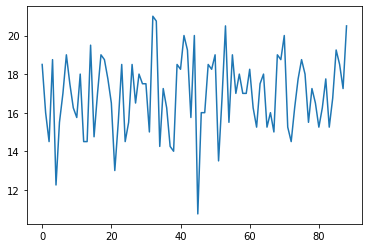

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [8.39502949e+07 5.93418567e+07 1.58775460e+08 1.25051881e+07] 
UE location : [24 34 53 44 43  5 37 93]
UE ID: 0 Speed: 18.977627158164978 Angle: 3.8850119496789186 Ratio: 0.9929768
Reward 37.433381957323554

Battery : 50000000 
UAV loc : [2.9455491994383465, 84.42290038816793] 
Task : 277139418.04267645 [5.55169130e+07 5.63418567e+07 1.55775460e+08 9.50518809e+06] 
UE location : [24 34 52 43 42  4 36 92]
UE ID: 0 Speed: 5.330802500247955 Angle: 1.5494542947735979 Ratio: 0.17459998
Reward 12.634601296823442

Battery : 50000000 
UAV loc : [94.0689279421548, 24.751110867748594] 
Task : 264504816.745853 [5.18823117e+07 5.33418567e+07 1.52775460e+08 6.50518809e+06] 
UE location : [23 33 51 42 42  4 35 92]
UE ID: 0 Speed: 32.45919942855835 Angle: 4.617173189990547 Ratio: 0.041145712
Reward 12.128733988025248

Battery : 50000000 
UAV loc : [98.29674600365479, 43.89386187999378] 
Task : 252376082.75782776 [4.87535777e+07 5.03418567e+07 1

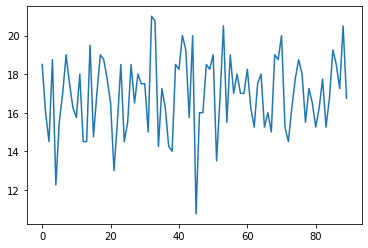

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.64856918e+07 1.58448256e+08 5.95989938e+05 1.39042862e+08] 
UE location : [23 49 57 79 76 82 72 22]
UE ID: 0 Speed: 6.07273131608963 Angle: 5.088934824939106 Ratio: 0.24828246
Reward 15.58685066690004

Battery : 50000000 
UAV loc : [23.30071355539758, 35.27223576327856] 
Task : 303985949.33309996 [1.24948311e+07 1.55448256e+08 0.00000000e+00 1.36042862e+08] 
UE location : [23 49 56 78 76 82 72 22]
UE ID: 0 Speed: 18.96788775920868 Angle: 0.2982311818400812 Ratio: 0.7955221
Reward 23.494831085261822

Battery : 50000000 
UAV loc : [56.868457615919965, 84.55688713873428] 
Task : 285491118.24783814 [0.00000000e+00 1.52448256e+08 0.00000000e+00 1.33042862e+08] 
UE location : [23 49 55 77 76 82 71 22]
UE ID: 2 Speed: 24.14920926094055 Angle: 6.136956041926595 Ratio: 0.43255863
Reward -44.0

Battery : 50000000 
UAV loc : [75.99353774402289, 96.18623976039657] 
Task : 279491118.24783814 [0.00000000e+00 1.49448256e+08 0.00000000e+00 1.

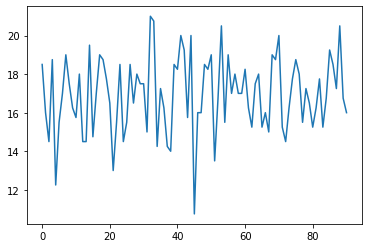

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [3.49704782e+07 3.35920690e+07 1.00035602e+08 1.45974651e+08] 
UE location : [26 14 70 98 46 25 78 90]
UE ID: 3 Speed: 24.28915649652481 Angle: 1.2929896347567975 Ratio: 0.74284256
Reward 20.666004849821032

Battery : 50000000 
UAV loc : [66.12306089664344, 64.21077559031119] 
Task : 293906795.15017897 [3.19704782e+07 3.05920690e+07 9.70356023e+07 1.34308646e+08] 
UE location : [25 14 70 98 45 24 77 90]
UE ID: 2 Speed: 1.7679765820503235 Angle: 5.607414713639028 Ratio: 0.33621082
Reward 13.5195072129485

Battery : 50000000 
UAV loc : [49.75192607276995, 89.50915321046296] 
Task : 280387287.93723047 [2.89704782e+07 2.75920690e+07 9.25160951e+07 1.31308646e+08] 
UE location : [24 13 69 97 45 23 76 90]
UE ID: 2 Speed: 37.58759796619415 Angle: 2.484966297575 Ratio: 0.5590215
Reward 15.80305233894068

Battery : 50000000 
UAV loc : [1.9562808824957756, 45.44353103046319] 
Task : 264584235.5982898 [2.59704782e+07 2.45920690e+07 8.571304

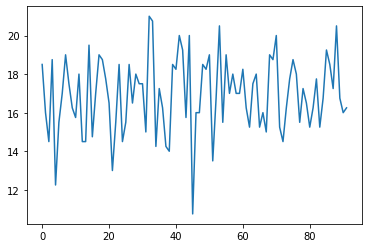

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [8.37454911e+06 1.70126881e+07 9.54640263e+07 1.93721537e+08] 
UE location : [76 46 10 63 37 46 76 67]
UE ID: 0 Speed: 12.348359823226929 Angle: 4.963365239901865 Ratio: 0.9542171
Reward 22.374549113212048

Battery : 50000000 
UAV loc : [93.32879104319431, 3.850898576678219] 
Task : 297198250.88678795 [0.00000000e+00 1.40126881e+07 9.24640263e+07 1.90721537e+08] 
UE location : [75 46 10 63 36 45 76 67]
UE ID: 1 Speed: 19.093874096870422 Angle: 1.8424777691317593 Ratio: 0.36415726
Reward 10.718147756900251

Battery : 50000000 
UAV loc : [20.491968354292567, 24.44292414767233] 
Task : 286480103.1298877 [0.00000000e+00 9.29454035e+06 8.94640263e+07 1.87721537e+08] 
UE location : [74 46  9 62 35 44 75 66]
UE ID: 0 Speed: 38.38520646095276 Angle: 6.08114101245801 Ratio: 0.17483595
Reward -41.0

Battery : 50000000 
UAV loc : [9.635797485219655, 74.00703703299598] 
Task : 277480103.1298877 [0.00000000e+00 6.29454035e+06 8.64640263e+07 1

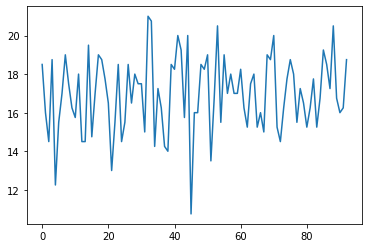

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [1.14605086e+08 4.58629619e+07 1.51525955e+08 2.57879697e+06] 
UE location : [15  8 48 52 96 74 99 54]
UE ID: 3 Speed: 12.634404003620148 Angle: 5.244761207299118 Ratio: 0.5824932
Reward 16.57879696838391

Battery : 50000000 
UAV loc : [41.2954245798403, 88.58707675586857] 
Task : 302994003.0316161 [1.11605086e+08 4.28629619e+07 1.48525955e+08 0.00000000e+00] 
UE location : [15  7 47 51 95 73 99 54]
UE ID: 3 Speed: 22.45253175497055 Angle: 5.037484300378241 Ratio: 0.26228875
Reward -41.0

Battery : 50000000 
UAV loc : [46.67433399288541, 68.93977981820285] 
Task : 293994003.0316161 [1.08605086e+08 3.98629619e+07 1.45525955e+08 0.00000000e+00] 
UE location : [14  6 47 50 94 72 99 54]
UE ID: 2 Speed: 12.593473494052887 Angle: 3.8938604272363833 Ratio: 0.232041
Reward 9.906458554631293

Battery : 50000000 
UAV loc : [52.06796839434844, 33.470584244048496] 
Task : 284087544.4769848 [1.05605086e+08 3.68629619e+07 1.41619496e+08 0.0000

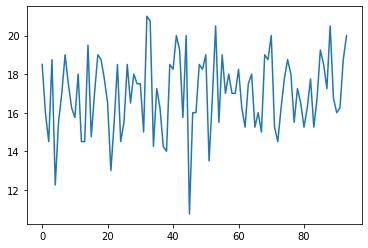

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.52211772e+08 6.02931506e+07 6.27358498e+05 1.44051937e+06] 
UE location : [13  5 60 18 89 32 60 67]
UE ID: 1 Speed: 32.31576383113861 Angle: 2.3985553546695257 Ratio: 0.15110704
Reward 18.601892343182804

Battery : 50000000 
UAV loc : [20.211756824383542, 13.748907937974764] 
Task : 305970907.6568172 [2.49211772e+08 5.67591361e+07 0.00000000e+00 0.00000000e+00] 
UE location : [13  5 60 17 88 32 59 67]
UE ID: 0 Speed: 9.008164703845978 Angle: 3.688233598282162 Ratio: 0.19720247
Reward 6.736932292872191

Battery : 50000000 
UAV loc : [51.630291834365494, 93.3721719774411] 
Task : 299233975.363945 [2.45474839e+08 5.37591361e+07 0.00000000e+00 0.00000000e+00] 
UE location : [13  5 59 17 88 32 59 66]
UE ID: 2 Speed: 14.567673206329346 Angle: 4.6684727882190105 Ratio: 0.3628251
Reward -44.0

Battery : 50000000 
UAV loc : [99.07407211451869, 81.85443533748185] 
Task : 293233975.363945 [2.42474839e+08 5.07591361e+07 0.00000000e+00 0.0

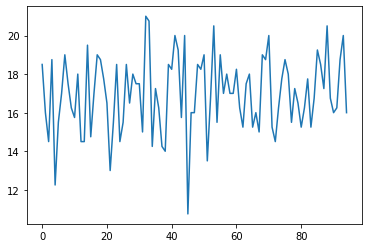

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [6.48332387e+07 5.69894884e+07 5.33381391e+07 1.39411934e+08] 
UE location : [97 56  8 38 98 19 51 35]
UE ID: 3 Speed: 32.31682777404785 Angle: 4.443955824757721 Ratio: 0.99811757
Reward 37.29754761312842

Battery : 50000000 
UAV loc : [57.11023772597059, 84.05141021870577] 
Task : 277275252.3868716 [6.18332387e+07 5.39894884e+07 5.03381391e+07 1.11114386e+08] 
UE location : [96 55  7 38 97 18 50 35]
UE ID: 3 Speed: 1.6196653246879578 Angle: 1.7033330533329754 Ratio: 0.7064144
Reward 19.218484883613975

Battery : 50000000 
UAV loc : [89.62005013964358, 34.31291525358802] 
Task : 258056767.5032576 [5.88332387e+07 5.09894884e+07 4.73381391e+07 1.00895901e+08] 
UE location : [96 54  7 38 97 18 49 35]
UE ID: 2 Speed: 10.684449970722198 Angle: 4.51100344352588 Ratio: 0.22485358
Reward 12.870236518073051

Battery : 50000000 
UAV loc : [51.7128954714849, 15.560597414528843] 
Task : 245186530.98518455 [55833238.70778051 47989488.42561137

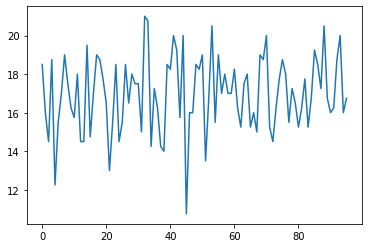

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [4.04212392e+07 9.30279643e+07 1.17245424e+08 6.38781723e+07] 
UE location : [56 55 92 86  5 32 69 49]
UE ID: 1 Speed: 44.516995549201965 Angle: 3.0263104021127156 Ratio: 0.1289872
Reward 12.444266233815075

Battery : 50000000 
UAV loc : [22.150763967113107, 87.93403938384756] 
Task : 302128533.7661849 [3.74212392e+07 8.95836981e+07 1.14245424e+08 6.08781723e+07] 
UE location : [55 55 91 85  5 31 69 48]
UE ID: 0 Speed: 18.287119269371033 Angle: 3.233541244669113 Ratio: 0.15683338
Reward 12.558015616936206

Battery : 50000000 
UAV loc : [5.910512974239168, 25.493288109430523] 
Task : 289570518.1492487 [3.38632236e+07 8.65836981e+07 1.11245424e+08 5.78781723e+07] 
UE location : [54 55 91 85  5 30 69 47]
UE ID: 2 Speed: 12.518680095672607 Angle: 3.4867667933982127 Ratio: 0.18676725
Reward 12.688980800520778

Battery : 50000000 
UAV loc : [13.022788473563196, 74.25393832573093] 
Task : 276881537.34872794 [3.08632236e+07 8.35836981e+0

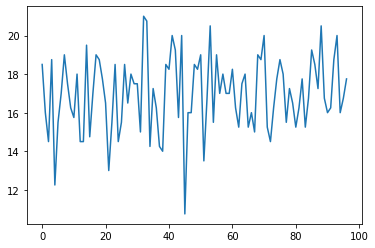

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [9.78379052e+07 6.15586132e+07 2.35202966e+06 1.52824252e+08] 
UE location : [25 64 89 54  9 27 40 21]
UE ID: 0 Speed: 48.29877316951752 Angle: 0.1621615432506061 Ratio: 0.27684122
Reward 17.500496216097535

Battery : 50000000 
UAV loc : [33.487755453768386, 20.207771649467077] 
Task : 302072303.78390247 [9.36894386e+07 5.85586132e+07 0.00000000e+00 1.49824252e+08] 
UE location : [25 64 89 53  9 27 40 20]
UE ID: 2 Speed: 22.8243425488472 Angle: 2.4694120844224465 Ratio: 0.88267696
Reward -41.0

Battery : 50000000 
UAV loc : [37.15097287256981, 42.03456573120832] 
Task : 293072303.78390247 [9.06894386e+07 5.55586132e+07 0.00000000e+00 1.46824252e+08] 
UE location : [25 64 89 52  8 27 39 19]
UE ID: 1 Speed: 2.127765119075775 Angle: 2.39903472366574 Ratio: 0.3699805
Reward 10.761757480364382

Battery : 50000000 
UAV loc : [41.66397024302455, 52.66934246306221] 
Task : 282310546.3035381 [8.76894386e+07 5.07968557e+07 0.00000000e+00 1

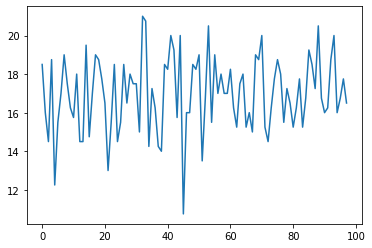

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [2.92129322e+07 1.16564202e+08 2.42480663e+07 1.44547599e+08] 
UE location : [84 95 35 45 10 50 94 96]
UE ID: 0 Speed: 15.959402918815613 Angle: 1.00525307611704 Ratio: 0.26496124
Reward 13.081417435620606

Battery : 50000000 
UAV loc : [55.22380219624097, 52.551424577541184] 
Task : 301491382.5643794 [2.51315147e+07 1.13564202e+08 2.12480663e+07 1.41547599e+08] 
UE location : [84 95 34 45  9 49 94 96]
UE ID: 1 Speed: 41.38023853302002 Angle: 4.6076303764026285 Ratio: 0.9893382
Reward 37.531304260130675

Battery : 50000000 
UAV loc : [89.67906872720732, 60.19606106895026] 
Task : 263960078.30424872 [2.21315147e+07 8.50328979e+07 1.82480663e+07 1.38547599e+08] 
UE location : [83 94 34 45  9 48 94 95]
UE ID: 3 Speed: 36.50061786174774 Angle: 0.9775399305304312 Ratio: 0.06896219
Reward 12.22221069514215

Battery : 50000000 
UAV loc : [8.524797595720202, 45.961923313888065] 
Task : 251737867.60910657 [1.91315147e+07 8.20328979e+07 1.

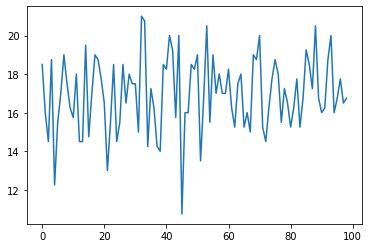

Battery : 50000000 
UAV loc : [50, 50] 
Task : 314572800 [4.55325622e+07 4.35018684e+07 2.14306559e+08 1.12318104e+07] 
UE location : [89 91  0 74 16 36 29 47]
UE ID: 2 Speed: 42.41819083690643 Angle: 0.25229508601730705 Ratio: 0.4497736
Reward 14.452301184658646

Battery : 50000000 
UAV loc : [92.46818304114299, 58.872755071536176] 
Task : 300120498.81534135 [4.25325622e+07 4.05018684e+07 2.08854258e+08 8.23181040e+06] 
UE location : [88 91  0 74 15 36 29 47]
UE ID: 0 Speed: 44.03310418128967 Angle: 6.027030364475183 Ratio: 0.51615053
Reward 15.20027552319038

Battery : 50000000 
UAV loc : [93.54547825610098, 28.359707359314257] 
Task : 284920223.292151 [3.63322867e+07 3.75018684e+07 2.05854258e+08 5.23181040e+06] 
UE location : [87 90  0 74 14 36 28 46]
UE ID: 0 Speed: 26.551184058189392 Angle: 6.17462920193064 Ratio: 0.37852836
Reward 13.82725162383312

Battery : 50000000 
UAV loc : [5.9629369472872895, 51.69280771478384] 
Task : 271092971.66831785 [3.15050351e+07 3.45018684e+07 2.0

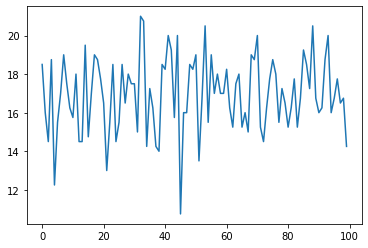

In [ ]:
agent.train(episodes)

In [ ]:
print(agent.average_delay)

[18.5, 16.0, 14.5, 18.75, 12.25, 15.5, 17.0, 19.0, 17.5, 16.25, 15.75, 18.0, 14.5, 14.5, 19.5, 14.75, 17.0, 19.0, 18.75, 17.75, 16.5, 13.0, 15.5, 18.5, 14.5, 15.5, 18.5, 16.5, 18.0, 17.5, 17.5, 15.0, 21.0, 20.75, 14.25, 17.25, 16.25, 14.25, 14.0, 18.5, 18.25, 20.0, 19.25, 15.75, 20.0, 10.75, 16.0, 16.0, 18.5, 18.25, 19.0, 13.5, 16.75, 20.5, 15.5, 19.0, 17.0, 18.0, 17.0, 17.0, 18.25, 16.25, 15.25, 17.5, 18.0, 15.25, 16.0, 15.0, 19.0, 18.75, 20.0, 15.25, 14.5, 16.25, 17.75, 18.75, 18.0, 15.5, 17.25, 16.5, 15.25, 16.25, 17.75, 15.25, 16.75, 19.25, 18.5, 17.25, 20.5, 16.75, 16.0, 16.25, 18.75, 20.0, 16.0, 16.75, 17.75, 16.5, 16.75, 14.25]
